# Import packages

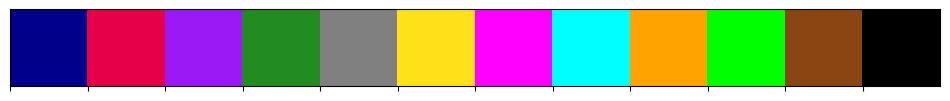

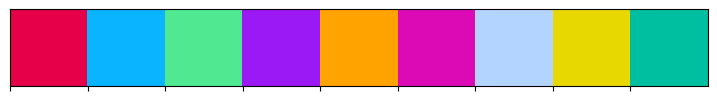

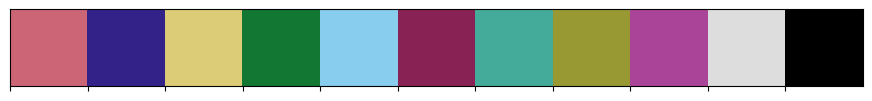

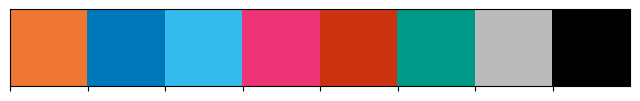

In [1]:
# Importing necessary packages:
from glob import glob
import re
import numpy as np
import pandas as pd
import itertools
from  matplotlib import colors as mplc
import matplotlib.pyplot as plt
import seaborn as sns

from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import TITLE_STYLES as TS
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.visualize.plotter import PAUL_TOL_MUTED as PTM
from polyphys.visualize.plotter import PAUL_TOL_VIBRANT as PTV

from polyphys.visualize import tuner
from polyphys.manage import organizer
from polyphys.manage import utilizer

sns.palplot(AC)
sns.palplot(DF_colors)
sns.palplot(PTM)
sns.palplot(PTV)


# PDF of distance between foci

## Importing datasets

In [ ]:
# loading databases
projects = ['TransFociCub', 'TransFociCyl']
pair_dist_properties = ['pairDistHistFoci', 'pairDistRdfFoci']
dcyl = 20
geometry_names_simple = {
    'TransFociCub': 'Free space',
    'TransFociCyl': fr'Cylindrical confinement',
}
geometry_orders_simple = ['Free space', 
                   fr'Cylindrical confinement']
# TransFociCyl added later
geometry_names_full = {
    'TransFociCub': 'Free space',
    'TransFociCyl': 'Cylindrical confinement', # defined later
}
geometry_orders_full = ['Free space'] # TransFocuCyl added later

project_foci_gen_dist = []
project_foci_pair_dist = []
project_titles = {}
project_title_style = ''
n_subchain = 0
for project in projects:
    #allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
    allInOne_db = '/Users/amirhsi_mini/research_data/do_not_delete/'+project+'-allInOne/'
    space_dbs = glob(allInOne_db + PD[project]['space_pat'])

    prop = pair_dist_properties[1]
    # LOad data
    dist_map = '-'.join(
        ['allInOne', project, PD[project]['group'],
         'pairDistStats.parquet.brotli']
        )
    dist_map = allInOne_db + dist_map
    dist_map = pd.read_parquet(dist_map)
    # rounding phi_c values:
    divisor = 0.025
    round_to = 3
    dist_map['phi_c_bulk_round'] = dist_map['phi_c_bulk'].apply(
            utilizer.round_up_nearest, args=[divisor, round_to] # type: ignore
            )
    # phi_c to drop
    phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
    dist_map = dist_map.loc[~dist_map['phi_c_bulk_round'].isin(phi_c_to_drop),:]
    dist_map.reset_index(inplace=True, drop=True)
    # Dropping pair distance cols of `prop_to_drop`
    prop_to_drop = pair_dist_properties[0]
    cols_to_drop = [
        col for col in dist_map.columns if col.startswith(prop_to_drop)
    ] + ['phi_c_bulk']
    dist_map.drop(columns=cols_to_drop, inplace=True)
    # Normalized bin_center:
    attributes = PD[project]['equil_attributes'].copy()
    attributes.remove('phi_c_bulk')
    dist_map['bin_center-norm-r-dmon_large'] = \
        dist_map['bin_center'] / dist_map['dmon_large']
    dist_map['bin_center-norm'] = \
        dist_map['bin_center'] / dist_map.groupby(attributes)['bin_center'].transform('max')
    # renaming pair distance cols of prop
    pair_tags = {
        col: col.split('-')[1] for col in dist_map.columns if 'genDist' in col
        }
    dist_map.rename(columns=pair_tags, inplace=True)
    # Now, just keep the new col names
    pair_tags = list(pair_tags.values())
    ## Scale 'prop' by its max value:
    attributes.extend(
        ['bin_center', 'bin_center-norm', 'bin_center-norm-r-dmon_large'])
    ## melting
    sel_cols = attributes + pair_tags
    pair_dist = dist_map[sel_cols].melt(
        id_vars=attributes,
        value_vars=pair_tags,
        var_name=prop,
        value_name='probability'
    )
    pair_dist.loc[:, 'index_difference'] = pair_dist.loc[
        :, 'pairDistRdfFoci'].str.split(r'(\d+\.*\d*)', regex=True).apply(
        lambda str_list: int(float(str_list[-2])))
    pair_dist['geometry'] = geometry_names_simple[project]
    if project == 'TransFociCyl':
        pair_dist['geometry_fullname'] = geometry_names_full[project] + pair_dist['dcyl'].apply(lambda x: f" ($D={x}$)")
    else:
        pair_dist['geometry_fullname'] = geometry_names_full[project]
    project_foci_pair_dist.append(pair_dist)
    ## Melting and averaging on pairs with the same index difference
    group_by_cols = pair_dist.columns.to_list()
    group_by_cols.remove('probability')
    group_by_cols.remove('pairDistRdfFoci')
    agg_dict = ['last'] * len(group_by_cols)
    agg_dict = dict(zip(group_by_cols,agg_dict))
    agg_dict['probability'] = 'mean'
    # averaging over genomic distance:
    gen_dist = pair_dist.groupby(group_by_cols).agg(agg_dict)
    gen_dist.reset_index(inplace=True, drop=True)
    gen_dist.rename(columns={'probability': 'pairDistRdfGenDistAvg'}, inplace=True)
    # norm by max:
    group_by_cols = PD[project]['equil_attributes'].copy()
    group_by_cols.remove('phi_c_bulk')
    group_by_cols.extend(['index_difference'])
    gen_dist['pairDistRdfGenDistAvg-norm_by_max'] = gen_dist['pairDistRdfGenDistAvg'] / gen_dist.groupby(group_by_cols)['pairDistRdfGenDistAvg'].transform('max')
    project_foci_gen_dist.append(gen_dist)
    # a sorted list of unique spaces in the dataset
    spaces = dist_map['space'].unique()
    spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
    for space in spaces:
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False)
        if project not in TS.keys():
                raise ValueError(f"Project: '{project}' is not defined.")
        style = TS[project]
        cond = gen_dist['space']==space
        gen_dist.loc[cond,'space_title'] = style['title'](s_info)
        gen_dist.loc[cond,'space_title_short'] = style['short'](s_info)
        gen_dist.loc[cond,'universe'] = style['universe'](s_info)
        n_subchain = s_info.nmon_small // s_info.nmon_large
        if s_info.dmon_large == 5.0:
            projects_comon_title = (
                fr"$N_s={s_info.nmon_small},$ " +
                fr"$N_l={s_info.nmon_large},$ " +
                fr"$a_c={s_info.dcrowd}$"
            )
            if project == 'TransFociCyl' and prop == 'clustersHistFoci':
                geometry_names_full[project] = \
                fr"Cylindrical confinement ($D={s_info.dcyl}$)"
                geometry_orders_full.append(
                fr"Cylindrical confinement ($D={s_info.dcyl}$)")
    project_titles[project] = projects_comon_title 

foci_pair_dist = pd.concat(project_foci_pair_dist, axis=0)
foci_pair_dist.reset_index(inplace=True, drop=True)
foci_gen_dist =  pd.concat(project_foci_gen_dist, axis=0)
foci_gen_dist.reset_index(inplace=True, drop=True)
# correcting genomic_distance:
# Currently, 'genomic_distance' is the number of monomers (size-indepedant)
# between two large monomers but it must be expressed in the number of bonds in
# the unit of the average bond between small monomers where it is assumed
# the average bond between a pair of large and small monomers and a pair of
# large monomers are 0.5*(dmon_large+dmon_small)*bond_small/dmon_small and
# dmon_large*bond_small/dmon_small.
if n_subchain == 0:
    raise ValueError(
        f"Number of small monomers 'n={n_subchain}'"
        " in a subchain cannot be 0.")
for df in [foci_pair_dist, foci_gen_dist]:
    df['genomic_distance'] = (df['index_difference']//n_subchain)*n_subchain + (df['index_difference']%n_subchain+1)*df['dmon_large']
pattern = r'\d+\.\d+'
foci_pair_dist['pair_names'] = foci_pair_dist['pairDistRdfFoci'].apply(lambda x: re.findall(pattern, x))
foci_pair_dist['pair_names'] = foci_pair_dist.apply(
    lambda x: r"$({0},{1},{2})$".format(
        int(float(x['pair_names'][0])),
        int(float(x['pair_names'][1])),
        (float(x['pair_names'][2])//n_subchain)*n_subchain + (float(x['pair_names'][2])%n_subchain+1)*x['dmon_large']), axis=1)
foci_pair_dist['pair_names-idx_diff'] = foci_pair_dist['pairDistRdfFoci'].apply(lambda x: re.findall(pattern, x))
foci_pair_dist['pair_names-idx_diff'] = foci_pair_dist.apply(
    lambda x: r"$({0},{1},{2})$".format(
        int(float(x['pair_names-idx_diff'][0])),
        int(float(x['pair_names-idx_diff'][1])),
        int(float(x['pair_names-idx_diff'][2])),), axis=1)


## Genomic distance matters not genomic position

### Per geometry per geonomic distance per phi_c per dmon_large

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1
index_diff_plot = True

plot_params = {
    'talk': {
    'height': 8,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'lw': 4
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'lw': 2
    }
}
fig_title_kws = {'y': 1.02}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
# Define filtering conditions
bin_center_cond = foci_pair_dist['bin_center-norm'] <= 0.3
dmon_large_chosen = 3
dmon_large_cond = foci_pair_dist['dmon_large'] == dmon_large_chosen
phi_c_chosen = 0.2
phi_c_cond = foci_pair_dist['phi_c_bulk_round'] == phi_c_chosen
index_diff_chosen = 161
gen_dist = (index_diff_chosen//n_subchain)*n_subchain + (index_diff_chosen%n_subchain+1)*dmon_large_chosen
index_diff_cond = foci_pair_dist['index_difference'] == index_diff_chosen
if index_diff_plot is True:
    title_based_cond = fr"$, a_l={dmon_large_chosen}, $" + \
        fr"$\phi_c={phi_c_chosen}, \Delta n={index_diff_chosen}$"
else:
    title_based_cond = fr"$, a_l{dmon_large_chosen}, $" + \
        fr"$\phi_c={phi_c_chosen}, \Delta n/\langle l_m \rangle={gen_dist}$"

# Loop through projects and filter data
for project in projects:
    geom_cond = \
        foci_pair_dist['geometry'] == geometry_names_simple[project]
    conds = bin_center_cond & dmon_large_cond & phi_c_cond \
        & geom_cond & index_diff_cond
    data = foci_pair_dist.loc[conds] # type: ignore
    data.reset_index(inplace=True, drop=True)
    x_prop = 'bin_center-norm-r-dmon_large'
    y_prop = 'probability'
    hue_attr = 'pairDistRdfFoci'
    if index_diff_plot is True:
        hue_order = sorted(
            data[hue_attr].unique(), key=organizer.sort_by_alphanumeric)
        unique_hue_names = data.drop_duplicates(
            subset=[hue_attr, 'pair_names-idx_diff'])[[hue_attr, 'pair_names-idx_diff']]
        unique_hue_names = dict(
            zip(unique_hue_names[hue_attr], unique_hue_names['pair_names-idx_diff']))
        leg_title = AL[hue_attr+'-legend_title-index_diff']
    else:
        hue_order = sorted(
            data[hue_attr].unique(), key=organizer.sort_by_alphanumeric)
        unique_hue_names = data.drop_duplicates(
            subset=[hue_attr, 'pair_names'])[[hue_attr, 'pair_names']]
        unique_hue_names = dict(
            zip(unique_hue_names[hue_attr], unique_hue_names['pair_names']))
        leg_title = AL[hue_attr+'-legend_title']
    hue_labels = [unique_hue_names[hue] for hue in hue_order]
    color_palette = PTM[:len(hue_labels)]
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                height = plot_params[plot_context]['height']
                aspect = plot_params[plot_context]['aspect']
                fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
                grid = sns.lineplot(
                    ax=ax,
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    hue_order=hue_order,
                    palette=color_palette,
                    legend='full',
                    alpha=0.7,
                    lw=plot_params[plot_context]['lw'],
                    )
                ax.set_xlabel(AL[x_prop])
                ax.set_ylabel(AL[hue_attr+'-short_name'])
                #handles, labels = ax.get_legend_handles_labels()
                #labels_new = hue_labels
                legend_grid = ax.legend(
                    #handles,
                    #labels_new,
                    frameon=False,
                    title=leg_title,
                    loc='best',
                    ncols=1
                    #bbox_to_anchor=(1,0.9)
                    )
                for idx, new_label in enumerate(hue_labels):
                    grid.legend_.legend_handles[idx].set_linewidth(plot_params[plot_context]['lw'])
                    grid.legend_.texts[idx].set_ha('left')
                    grid.legend_.texts[idx].set_text(new_label)
                #for handle in legend_grid.legend_handles:
                #    handle.set_linewidth(2) 
                if plot_context == 'talk':
                    title = project_titles[project] \
                        + title_based_cond
                    ax.set_title(title, **fig_title_kws)
                if project == 'TransFociCub':
                    output = "-".join(
                        ["Genomic_distance_matters", project,
                         f"nmon_s{nmon_small}",f"nmon_l{nmon_large}",
                         f"dcrowd{dcrowd}", f"dmon_large{dmon_large_chosen}",
                         f"phi_c{phi_c_chosen}",
                         f"index_diff{index_diff_chosen}",
                        plot_context])
                else:
                    output = "-".join(
                    ["Genomic_distance_matters", project, f"nmon_s{nmon_small}",
                    f"nmon_l{nmon_large}", f"dcyl{dcyl}",
                    f"dcrowd{dcrowd}", f"dmon_large{dmon_large_chosen}",
                    f"phi_c{phi_c_chosen}", f"index_diff{index_diff_chosen}",
                    plot_context])
                fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
                #plt.show()
                plt.close()

### Not need: incomplete: Per geometry genomic distance as line style per phi_c per dmon_large

In [ ]:
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.2,
    },
    'paper': {
    'height': 4,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.2
    }
}
save_to = './'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
# Define filtering conditions
bin_center_cond = foci_pair_dist['bin_center-norm'] <= 0.3
dmon_large_chosen = 3
dmon_large_cond = foci_pair_dist['dmon_large'] == dmon_large_chosen
phi_c_chosen = 0.2
phi_c_cond = foci_pair_dist['phi_c_bulk_round'] == phi_c_chosen
title_based_cond = \
    fr"$, a_M/a_m={dmon_large_chosen}, \phi_c={phi_c_chosen}$"

# Loop through projects and filter data
for project in projects:
    geom_cond = \
        foci_pair_dist['geometry'] == geometry_names_simple[project]
    conds = bin_center_cond & dmon_large_cond & phi_c_cond \
        & geom_cond
    data = foci_pair_dist.loc[conds] # type: ignore
    data.reset_index(inplace=True, drop=True)
    x_prop = 'bin_center-norm-r-dmon_large'
    y_prop = 'probability'

    col_attr = 'geometry'
    #col_order = sorted(data[col_attr].unique())
    col_order = geometry_orders_simple
    hue_attr = 'pairDistRdfFoci'
    hue_order = sorted(
        data[hue_attr].unique(), key=organizer.sort_by_alphanumeric)
    unique_hue_names = data.drop_duplicates(subset=[hue_attr, 'pair_names'])[[hue_attr, 'pair_names']]
    unique_hue_names = dict(
        zip(unique_hue_names[hue_attr], unique_hue_names['pair_names']))
    hue_labels = [unique_hue_names[hue] for hue in hue_order]    
    color_palette = AC[: len(hue_labels)]
    style_attr = 'genomic_distance'
    style_order = sorted(data[style_attr].unique())
    for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
        sns.set_theme(
            context=plot_context,
            style='ticks',
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
        )
        grid = sns.lineplot(
            ax=ax,
            data=data,
            x=x_prop,
            y=y_prop,
            hue=hue_attr,
            hue_order=hue_order,
            style=style_attr, 
            style_order=style_order,
            markers=True,
            dashes=False,
            palette=color_palette,
            legend='full',
            alpha=0.7,
            lw=1,
            markersize=5
            )
        ax.set_xlabel(AL[x_prop])
        ax.set_ylabel(AL[hue_attr])
        handles, labels = ax.get_legend_handles_labels()
        labels_new = [AL[hue_attr]] + hue_labels + [AL[style_attr]] + style_order
        ax.legend(
            handles,
            labels_new,
            frameon=False,
            #title=AL[hue_attr+'-legend_title'],
            loc='best',
            bbox_to_anchor=(1,1)
            )
        if plot_context == 'talk':
            title = project_title_style + title_based_cond
            ax.set_title(title)
        output = "-".join(
            ["Genomic_distance_matters", project, col_attr, hue_attr,
            plot_context, f"dmon_large{dmon_large_chosen}",
            f"phi_c{phi_c_chosen}"])
        fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
        plt.show()
        #plt.close()

### Not need: incompleteneeded: genomic distance as col per geometry per phi_c per dmon_large

In [ ]:
plot_params = {
    'talk': {
    'height': 6,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (0.65,0.84)
    },
    'paper': {
    'height': 4,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2
    }
}
save_to = './'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'row',
    'legend_out': True
}
# Define filtering conditions
bin_center_cond = foci_pair_dist['bin_center-norm'] <= 0.3
dmon_large_chosen = 3
dmon_large_cond = foci_pair_dist['dmon_large'] == dmon_large_chosen
phi_c_chosen = 0.2
phi_c_cond = foci_pair_dist['phi_c_bulk_round'] == phi_c_chosen
geom_chosen = 'Free Space'
geom_cond = foci_pair_dist['geometry'] == geom_chosen
title_based_cond = \
    fr"$, a_M/a_m={dmon_large_chosen}, \phi_c={phi_c_chosen}, \Delta n/\langle l_m \rangle={gen_dist}$"

conds = bin_center_cond & dmon_large_cond & phi_c_cond \
    & geom_cond
data = foci_pair_dist.loc[conds] # type: ignore
data.reset_index(inplace=True, drop=True)

x_prop = 'bin_center-norm-r-dmon_large'
y_prop = 'probability'

col_attr = 'genomic_distance'
col_order = sorted(data[col_attr].unique())
#col_order = geometry_orders_simple

hue_attr = 'pairDistRdfFoci'
hue_order = sorted(
    data[hue_attr].unique(), key=organizer.sort_by_alphanumeric)
unique_hue_names = data.drop_duplicates(subset=[hue_attr, 'pair_names'])[[hue_attr, 'pair_names']]
unique_hue_names = dict(
    zip(unique_hue_names[hue_attr], unique_hue_names['pair_names']))
hue_labels = [unique_hue_names[hue] for hue in hue_order]

color_palette = AC[: len(hue_labels)]
for plot_context in ['paper', 'talk']:
    sns.set_theme(
            context=plot_context,
            style='ticks',
            font=font_family,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
        )   
    grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        #col_wrap=1,
        hue=hue_attr,
        kind='line',
        height=plot_params[plot_context]['height'],
        aspect=plot_params[plot_context]['aspect'],
        palette=color_palette,
        facet_kws=facet_kws,
        legend='full',
        alpha=0.7,
        errorbar=None,
        )
    #grid.legend.set_title(AL[hue_attr+'-legend_title'])
    grid.set_ylabels(AL[hue_attr])
    grid.set_xlabels(AL[x_prop])
    if plot_context == 'talk':
        grid.set_titles('{col_name}')
    else:
        grid.set_titles('')
    for t, l in zip(grid._legend.texts, hue_labels): t.set_text(l)
    #grid.set(ylim=(0,0.05), xlim=(0,7))
    grid.tight_layout(w_pad=0.25, h_pad=0.25)
    sns.move_legend(grid, loc='upper left', bbox_to_anchor=(0.75,0.9))
    output = "-".join(
        ["Genomic_distance_matters", col_attr, hue_attr,
         plot_context,  f"dmon_large{dmon_large_chosen}",
         f"phi_c{phi_c_chosen}", geom_chosen])
    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
    plt.show()
    #plt.close()

### Not need: incomplete: per genomic distance per phi_c per dmon_large

In [ ]:
plot_params = {
    'talk': {
    'height': 6,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (0.65,0.84)
    },
    'paper': {
    'height': 4,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2
    }
}
save_to = './'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'row',
    'legend_out': True
}
# Define filtering conditions
bin_center_cond = foci_pair_dist['bin_center-norm'] <= 0.3
dmon_large_chosen = 3
dmon_large_cond = foci_pair_dist['dmon_large'] == dmon_large_chosen
phi_c_chosen = 0.2
phi_c_cond = foci_pair_dist['phi_c_bulk_round'] == phi_c_chosen
index_diff_chosen = 161
gen_dist = (index_diff_chosen//n_subchain)*n_subchain + (index_diff_chosen%n_subchain+1)*dmon_large_chosen
index_diff_cond = foci_pair_dist['index_difference'] == index_diff_chosen
title_based_cond = \
    fr"$, a_M/a_m={dmon_large_chosen}, \phi_c={phi_c_chosen}, \Delta n/\langle l_m \rangle={gen_dist}$"

conds = bin_center_cond & dmon_large_cond & phi_c_cond \
    & index_diff_cond
data = foci_pair_dist.loc[conds] # type: ignore
data.reset_index(inplace=True, drop=True)

x_prop = 'bin_center-norm-r-dmon_large'
y_prop = 'probability'

col_attr = 'geometry'
#col_order = sorted(data[col_attr].unique())
col_order = geometry_orders_simple

hue_attr = 'pairDistRdfFoci'
hue_order = sorted(
    data[hue_attr].unique(), key=organizer.sort_by_alphanumeric)
unique_hue_names = data.drop_duplicates(subset=[hue_attr, 'pair_names'])[[hue_attr, 'pair_names']]
unique_hue_names = dict(
    zip(unique_hue_names[hue_attr], unique_hue_names['pair_names']))
hue_labels = [unique_hue_names[hue] for hue in hue_order]

color_palette = DF_colors[: len(hue_labels)]
for plot_context in ['paper', 'talk']:
    sns.set_theme(
            context=plot_context,
            style='ticks',
            font=font_family,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
        )   
    grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        hue=hue_attr,
        kind='line',
        height=plot_params[plot_context]['height'],
        aspect=plot_params[plot_context]['aspect'],
        palette=color_palette,
        facet_kws=facet_kws,
        legend='full',
        alpha=0.7,
        errorbar=None,
        )
    grid.legend.set_title(AL[hue_attr+'-legend_title'])
    grid.set_ylabels(AL[hue_attr])
    grid.set_xlabels(AL[x_prop])
    if plot_context == 'talk':
        grid.set_titles('{col_name}')
    else:
        grid.set_titles('')
    for t, l in zip(grid._legend.texts, hue_labels): t.set_text(l)
    #grid.set(ylim=(0,0.05), xlim=(0,7))
    grid.tight_layout(w_pad=0.25, h_pad=0.25)
    sns.move_legend(grid, loc='upper left', bbox_to_anchor=(0.75,0.9))
    output = "-".join(
        ["Genomic_distance_matters", col_attr, hue_attr,
         plot_context,  f"dmon_large{dmon_large_chosen}",
         f"phi_c{phi_c_chosen}", f"index_diff{index_diff_chosen}"])
    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
    plt.show()
    #plt.close()

## Difference in values of $\Delta n_{ij}$

### Not needed: single space, single $\phi_c$, single $a_M$, single geometry, $\Delta n$ as hue

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 6,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 2.5
    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 1.5
    }
}
fig_title_kws = {'y': 1.02}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'row',
    'legend_out': True
}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center-norm']<=0.6)
dmon_large_chosen = 5
dmon_large_cond = (foci_gen_dist['dmon_large'] == dmon_large_chosen)
phi_c_chosen = 0.2
phic_cond = (foci_gen_dist['phi_c_bulk_round'] == phi_c_chosen)
title_based_cond = \
    fr"$, a_l={dmon_large_chosen}, \phi_c={phi_c_chosen}$"
for project in projects:
    geom_cond = \
        foci_gen_dist['geometry'] == geometry_names_simple[project]
    conds = bin_center_cond & dmon_large_cond & phic_cond \
        & geom_cond
    data = foci_gen_dist.loc[conds]
    data.reset_index(inplace=True, drop=True)
    
    dcrowds = data['dcrowd'].unique()
    if len(dcrowds) == 1:
        dcrowd = dcrowds[0]
    else:
        raise ValueError("There are more than one unique 'dcrowd' values in"
                         "oin the dataset.")
    x_prop = 'bin_center-norm-r-dmon_large'
    y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
    y_prop_name = 'pairDistRdfGenDistAvg'
    hue_attr = 'index_difference'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = PTM[:len(hue_order)]
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                height = plot_params[plot_context]['height']
                aspect = plot_params[plot_context]['aspect']
                fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
                grid = sns.lineplot(
                    ax=ax,
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    hue_order=hue_order,
                    palette=color_palette,
                    legend='full',
                    lw=plot_params[plot_context]['lw'],
                    )
                r_thres_min = 1
                ax.axvline(x=r_thres_min, label=r"$r=a_l$", lw=1.5, ls='--',
                           color='black', zorder=0)
                bin_center_max = data['bin_center'].max()
                r_thres_max = (dmon_large_chosen+dcrowd)/dmon_large_chosen
                x_range = np.linspace(0, r_thres_max, 100)
                y_min, y_max = ax.get_ylim()
                ax.fill_between(x_range, y_min, y_max, color='forestgreen',
                                alpha=0.2, zorder=0, label=r"$r \leq r_{thres}=a_l+a_c$")
                ax.set_xlabel(AL[x_prop])
                ax.set_ylabel(AL[y_prop_name+'-short_name'])
                ax.legend(
                    frameon=False,
                    loc='best',
                    #bbox_to_anchor=(1,0.9)
                    )
                for idx, new_label in enumerate(hue_order):
                    grid.legend_.legend_handles[idx].set_linewidth(plot_params[plot_context]['lw'])
                    grid.legend_.texts[idx].set_ha('left')
                    grid.legend_.texts[idx].set_text(AL[hue_attr] + fr"$={new_label}$")
                if plot_context == 'talk':
                    title = project_titles[project] \
                        + title_based_cond
                    ax.set_title(title, **fig_title_kws)
                if project == 'TransFociCub':
                    output = "-".join(
                    ["Genomic_distance-alone", project, f"nmon_s{nmon_small}",
                    f"nmon_l{nmon_large}", 
                    f"dcrowd{dcrowd}", f"dmon_large{dmon_large_chosen}",
                    f"phi_c{phi_c_chosen}", plot_context])
                else:
                    output = "-".join(
                    ["Genomic_distance-alone", project, f"nmon_s{nmon_small}",
                    f"nmon_l{nmon_large}", f"dcyl{dcyl}",
                    f"dcrowd{dcrowd}", f"dmon_large{dmon_large_chosen}",
                    f"phi_c{phi_c_chosen}", plot_context])
                fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
                plt.close()  

### Single $\phi_c=0$, single $a_M=1$, $\Delta n$ as row, Geometry as col: confinement alone

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 3,
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2.2,
    'lw': 3,
    }
}
fig_title_kws = {'y': 0.9, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}

legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2
}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center']<=30)
dmon_large_chosens = [1]
dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosens))
phi_c_chosens = [0]
phic_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosens))

conds = bin_center_cond & phic_cond & dmon_large_cond
data = foci_gen_dist.loc[conds]
data.reset_index(inplace=True, drop=True)

dcrowds = data['dcrowd'].unique()
if len(dcrowds) == 1:
    dcrowd = dcrowds[0]
else:
    raise ValueError("There are more than one unique 'dcrowd' values in"
                        "oin the dataset.")
x_prop = 'bin_center'
y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
y_prop_name = 'pairDistRdfGenDistAvg'

col_attr = 'geometry_fullname'
col_name = 'geometry_fullname'
col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

hue_attr = 'index_difference'
hue_order = sorted(data[hue_attr].unique())
color_palette = PTM[:len(hue_order)]
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                hue=hue_attr,
                hue_order=hue_order,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                errorbar=None,
                lw=plot_params[plot_context]['lw']
                )
            grid.set_titles("{col_name}")
            grid.set_ylabels(AL[y_prop_name+'-short_name'])
            grid.set_xlabels(AL[x_prop+'-foci'])
            legend_labels = hue_order
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                grid._legend.legend_handles[idx].set_linewidth(plot_params[plot_context]['lw'])
                grid._legend.texts[idx].set_ha('left')
            
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            grid.axes[0,-1].legend(
                handles,
                hue_order,
                title=r"$\Delta n$",
                loc='upper right',
                frameon=False
            ) 
            grid._legend.remove()
            if plot_context == 'talk':
                project_title_style = r"$N_s=400, N_l=5, a_c=1$"
                grid.fig.suptitle(project_title_style, **fig_title_kws)
            grid.tight_layout(w_pad=0.35, h_pad=0.25)
            output = "-".join(
                ["Genomic_distance-confinement", f"nmon_s{nmon_small}",
                f"nmon_l{nmon_large}",f"dcyl{dcyl}",
                f"dcrowd{dcrowd}", plot_context])
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

### Not needed: Incomplete: single space, $\phi_c$ as row, $a_l$ as col, $\Delta n$ (index_diff) as line style

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 2
    },
    'paper': {
    'height': 3,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 1
    }
}
fig_title_kws = {'y': 1.02}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}

legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.2,
    'edgecolor': 'black',
    'markerscale': 2
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)

# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center-norm']<=0.35)
#dmon_large_chosens = [3, 5]
#dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosens))
phi_c_chosens = [0, 0.1, 0.2, 0.3, 0.4]
phic_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosens))

for project in projects:
    geom_cond = \
        foci_gen_dist['geometry'] == geometry_names_simple[project]
    conds = bin_center_cond  & phic_cond & geom_cond
    data = foci_gen_dist.loc[conds]
    data.reset_index(inplace=True, drop=True)
    
    dcrowds = data['dcrowd'].unique()
    if len(dcrowds) == 1:
        dcrowd = dcrowds[0]
    else:
        raise ValueError("There are more than one unique 'dcrowd' values in"
                         "oin the dataset.")
    x_prop = 'bin_center-norm-r-dmon_large'
    y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
    y_prop_name = 'pairDistRdfGenDistAvg'

    row_attr = 'phi_c_bulk_round'
    row_order = sorted(data[row_attr].unique())

    col_attr = 'dmon_large'
    col_order = sorted(data[col_attr].unique())

    style_attr = 'index_difference'
    style_order = sorted(data[style_attr].unique())
 
    hue_attr = 'index_difference'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = AC[:len(hue_order)]
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    style=style_attr,
                    style_order=style_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    kind='line',
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    errorbar=None,
                    lw=2
                    )
                grid.map(plt.axvline,x=1, label=r"$r=a_M$", lw=2, ls=':', color='black', zorder=0)
                for idx, row in enumerate(row_order):
                    data_row = data.loc[data[row_attr]==row,:]
                    for idx_col, (ax, col) in enumerate(zip(grid.axes[idx,:], col_order)):
                        bin_center_max = data_row.loc[data_row[col_attr]==col, 'bin_center'].max()
                        y_max = data_row.loc[data_row[col_attr]==col, y_prop].max()
                        dcrowd = data_row.loc[data_row[col_attr]==col, 'dcrowd'].unique()[0]
                        dmon_large = data_row.loc[data_row[col_attr]==col, 'dmon_large'].unique()[0]
                        x_range = np.linspace(0, (dmon_large+dcrowd)/dmon_large,100)
                        ax.fill_between(
                            x_range,0, 1.05*y_max,color='gray', alpha=0.2, zorder=0, label='Direct contact'
                        )
                grid.set_titles(
                    AL[row_attr] + r"$={row_name},$ " + AL[col_attr] + r"$={col_name}$",
                    x=0.9, y=0.9)
                grid.set_ylabels(AL[y_prop_name])
                grid.set_xlabels(AL[x_prop])
                fill_color_patch = tuner.color_handler(
                    ['Direct contact'], ['gray'], alpha=0.2
                )
                vl_patch = tuner.ls_handler([r'$r=a_M$'], [':'], color='black', lw=2)
                grid.figure.legend(
                    handles=fill_color_patch+vl_patch,
                    loc='upper left',
                    bbox_to_anchor=(0.7, 0.20),
                    **legend_kws
                )
                sns.move_legend(
                    grid,
                    loc='upper left',
                    bbox_to_anchor=(0.81, 0.36),
                    **legend_kws)
                if plot_context == 'talk':
                    grid.fig.suptitle(project_title_style)#, **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.25)
                output = "-".join(
                    ["Genomic_distance_explained", project, f"nmon_s{nmon_small}",
                    f"nmon_l{nmon_large}",f"dcyl{dcyl}",
                    f"dcrowd{dcrowd}", plot_context])
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                plt.close()

### $\phi_c$ as row, $a_l$ as col, Geometry as style, $\Delta n$ as hue: all in one

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.4,
    'lw': 2.5,
    },
    'paper': {
    'height': 3.8,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2.8,
    'lw': 2.5,
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}

legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2
}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center']<=30)
dmon_large_chosens = [3, 4, 5, 6]
dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosens))
phi_c_chosens = [0.1, 0.2, 0.3, 0.4]
phic_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosens))

conds = bin_center_cond & phic_cond & dmon_large_cond
data = foci_gen_dist.loc[conds]
data.reset_index(inplace=True, drop=True)

dcrowds = data['dcrowd'].unique()
if len(dcrowds) == 1:
    dcrowd = dcrowds[0]
else:
    raise ValueError("There are more than one unique 'dcrowd' values in"
                        "oin the dataset.")
x_prop = 'bin_center-norm-r-dmon_large'
y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
y_prop_name = 'pairDistRdfGenDistAvg'

row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())

col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique())

style_attr = 'geometry'
style_attr_name = 'geometry'
style_order = ['Free space', 'Cylindrical confinement'] # sorted(data[style_attr].unique())

hue_attr = 'index_difference'
hue_order = sorted(data[hue_attr].unique())
color_palette = PTM[:len(hue_order)]
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                style=style_attr,
                style_order=style_order,
                markers=False,
                dashes=True,
                hue=hue_attr,
                hue_order=hue_order,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                errorbar=None,
                lw=plot_params[plot_context]['lw']
                )
            for idx, row in enumerate(row_order):
                data_row = data.loc[data[row_attr]==row,:]
                for idx_col, (ax, col) in enumerate(zip(grid.axes[idx,:], col_order)):
                    bin_center_max = \
                        data_row.loc[data_row[col_attr]==col, x_prop].max()
                    y_max = \
                        data_row.loc[data_row[col_attr]==col, y_prop].max()
                    dcrowd = \
                        data_row.loc[data_row[col_attr]==col, 'dcrowd'].unique()[0]
                    dmon_large = \
                        data_row.loc[data_row[col_attr]==col, col_attr].unique()[0]
                    x_range = np.linspace(0, (dmon_large+dcrowd)/dmon_large,100)
                    ax.fill_between(
                        x_range,0, 1.05*y_max,color=PTM[3],
                        alpha=0.4, zorder=0, label=r"$r \leq r_{thres}$",
                        edgecolor='none'
                    )
            grid.set_titles(
                AL[row_attr] + r"$={row_name},$ " + AL[col_attr] + r"$={col_name}$")
            grid.set_ylabels(AL[y_prop_name+'-short_name'])
            grid.set_xlabels(AL[x_prop])
            fill_color_patch = tuner.color_handler(
                [r"$r \leq r_{thres}$"], [PTM[3]], alpha=0.4
            )
            grid = grid.map(plt.axvline,x=1, label=r"$r=a_l$", lw=3, ls='-', color='darkgray', zorder=0)
            vl_patch = tuner.ls_handler([r'$r=a_l$'], ['-'], color='darkgray', lw=3)
            grid.axes[3,-3 ].legend(
                handles=fill_color_patch+vl_patch,
                loc='upper right',
                handletextpad=0.5,
                frameon=False
            )
            legend_labels = [r"$\Delta n$"] + hue_order + \
                [AL[style_attr_name]] + style_order
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                grid._legend.legend_handles[idx].set_linewidth(3)
                grid._legend.texts[idx].set_ha('left')
        
            handles = grid._legend.legend_handles[len(hue_order)+1:]
            grid.axes[3,-2].legend(
                handles,
                [AL[style_attr_name]] + style_order,
                loc='upper right',
                handletextpad=0.5,
                frameon=False
            )
            
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            grid.axes[3,-1].legend(
                handles,
                [r"$\Delta n$"] + hue_order,
                loc='upper right',
                handletextpad=0.5,
                frameon=False
            ) 
            grid._legend.remove()
            if plot_context == 'talk':
                project_title_style = r"$N_s=400, N_l=5, a_c=1$"
                grid.fig.suptitle(project_title_style, **fig_title_kws)
            grid.tight_layout(w_pad=0.35, h_pad=0.25)
            output = "-".join(
                ["Genomic_distance-all_params", f"nmon_s{nmon_small}",
                f"nmon_l{nmon_large}",f"dcyl{dcyl}",
                f"dcrowd{dcrowd}", plot_context])
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

### $\phi_c=0$, $a_l$ as hue, Geometry as row, $\Delta n$ as col: Confinement and chain heterogeneity

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 2.5,
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2.1,
    'lw': 2.5,
    }
}
fig_title_kws = {'y': 0.94, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}

legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 3
}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center']<=30)
dmon_large_chosens = [1, 3, 4, 5, 6]
dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosens))
phi_c_chosens = [0]
phic_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosens))

conds = bin_center_cond & phic_cond & dmon_large_cond
data = foci_gen_dist.loc[conds]
data.reset_index(inplace=True, drop=True)

dcrowds = data['dcrowd'].unique()
if len(dcrowds) == 1:
    dcrowd = dcrowds[0]
else:
    raise ValueError("There are more than one unique 'dcrowd' values in"
                        "oin the dataset.")
x_prop = 'bin_center'
y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
y_prop_name = 'pairDistRdfGenDistAvg'

row_attr = 'geometry_fullname'
row_order = list(reversed(sorted(data[row_attr].unique()))) # only for 'geometry_names_full' col


col_attr = 'index_difference'
col_order = sorted(data[col_attr].unique())

hue_attr = 'dmon_large'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'crest'
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                errorbar=None,
                lw=plot_params[plot_context]['lw'],
                )

            grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
            grid.set_ylabels(AL[y_prop_name+'-short_name'])
            grid.set_xlabels(AL[x_prop+'-foci'])
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                grid._legend.legend_handles[idx].set_linewidth(plot_params[plot_context]['lw'])
                grid._legend.texts[idx].set_ha('left')
            grid.axes[-1,-1].legend(
                handles,
                hue_order,
                title=AL[hue_attr],
                loc='upper right',
                markerscale=1.2,
                frameon=False
            ) 
            grid._legend.remove()
            if plot_context == 'talk':
                project_title_style = r"$N_s=400, N_l=5, a_c=1$"
                grid.fig.suptitle(project_title_style, **fig_title_kws)
            grid.tight_layout(w_pad=0.35, h_pad=0.25)
            output = "-".join(
                ["Genomic_distance-confinement-chain_heterogeneity", f"nmon_s{nmon_small}",
                f"nmon_l{nmon_large}",f"dcyl{dcyl}",
                f"dcrowd{dcrowd}", plot_context])
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

### $a_l=1$, $\phi_c$ as hue, Geometry as row, $\Delta n$ as col: Confinement and crowding

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1

plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 2.5,
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2.1,
    'lw': 2.5,
    }
}
fig_title_kws = {'y': 0.94, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}

legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 3
}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
bin_center_cond = (foci_gen_dist['bin_center']<=30)
dmon_large_chosens = [1]
dmon_large_cond = (foci_gen_dist['dmon_large'].isin(dmon_large_chosens))
phi_c_chosens = [0, 0.1, 0.2, 0.3, 0.4]
phic_cond = (foci_gen_dist['phi_c_bulk_round'].isin(phi_c_chosens))

conds = bin_center_cond & phic_cond & dmon_large_cond
data = foci_gen_dist.loc[conds]
data.reset_index(inplace=True, drop=True)

dcrowds = data['dcrowd'].unique()
if len(dcrowds) == 1:
    dcrowd = dcrowds[0]
else:
    raise ValueError("There are more than one unique 'dcrowd' values in"
                        "oin the dataset.")
x_prop = 'bin_center'
y_prop = 'pairDistRdfGenDistAvg-norm_by_max'
y_prop_name = 'pairDistRdfGenDistAvg'

row_attr = 'geometry_fullname'
row_order = list(reversed(sorted(data[row_attr].unique()))) # only for 'geometry_names_full' col


col_attr = 'index_difference'
col_order = sorted(data[col_attr].unique())

hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'flare'
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                errorbar=None,
                lw=plot_params[plot_context]['lw'],
                )

            grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
            grid.set_ylabels(AL[y_prop_name+'-short_name'])
            grid.set_xlabels(AL[x_prop+'-foci'])
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                grid._legend.legend_handles[idx].set_linewidth(plot_params[plot_context]['lw'])
                grid._legend.texts[idx].set_ha('left')
            grid.axes[-1,-1].legend(
                handles,
                hue_order,
                title=AL[hue_attr],
                loc='upper right',
                markerscale=1.2,
                frameon=False
            ) 
            grid._legend.remove()
            if plot_context == 'talk':
                project_title_style = r"$N_s=400, N_l=5, a_c=1$"
                grid.fig.suptitle(project_title_style, **fig_title_kws)
            grid.tight_layout(w_pad=0.35, h_pad=0.25)
            output = "-".join(
                ["Genomic_distance-confinement-crowding", f"nmon_s{nmon_small}",
                f"nmon_l{nmon_large}",f"dcyl{dcyl}",
                f"dcrowd{dcrowd}", plot_context])
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

# Choice of bonding threshold
- Data generation and viz is only for **TransFoci** project.

## Generating data

In [ ]:
# Importing necessary packages:
from glob import glob
import numpy as np
import pandas as pd

from polyphys.analyze import clusters
from polyphys.manage.parser import TransFociCub
probe_path = "/Users/amirhsi_mini/research_data/ns*-probe/al*.ring/al*ens*-bug-distMatTFoci.npy"
# probe_path = "./al*ens1*-bug-distMatTFoci.npy"
paths = sorted(glob(probe_path))
lj_cut = 2**(1/6)
for path in paths:
    bonding = {
        'dcrowd': [],
        'phi_c_bulk': [],
        'dmon_large': [],
        'rcut': [],
        'bond_freq_mean': [],
        'ensemble_id': [],
        'whole': []
    }
    bonding_df_list = []
    print(path)
    foci_dist_t = np.load(path)
    sim_info = TransFociCub(
        path,
        'whole',
        'cubic',
        'bug',
        'ring'
    )
    whole = sim_info.whole
    rcut_min = sim_info.dmon_large + sim_info.dcrowd
    rcut_max = np.round(lj_cut * (sim_info.dmon_large + sim_info.dcrowd), 3)
    rcuts = np.arange(rcut_min, rcut_max, 0.035)
    # (d_m_large+d_crowd) <= rcut <= 1.122460*(dm_mon_large+d_crowd), so
    # 0.89 <= r_cut_norm <= 1
    # dr_cut = 0.035 so the number of rcut increases with d_mon_large.
    for rcut in rcuts:
        print(rcut)
        bonds_t = np.empty([0, sim_info.nmon_large], dtype=int)
        bonding['dcrowd'].append(sim_info.dcrowd)
        bonding['phi_c_bulk'].append(round(sim_info.phi_c_bulk, 3))
        bonding['dmon_large'].append(sim_info.dmon_large)
        bonding['rcut'].append(rcut)
        bonding['ensemble_id'].append(sim_info.ensemble_id)
        bonding['whole'].append(sim_info.whole)
        n_frames = len(foci_dist_t)
        # The foci_dist_t has a especial structure, at a given time, foci_dist
        # is upper trinagle matrix where the diagonal elements are the index of
        # foci, and the upper traingle elements are the distance between large
        # monomers i and j. This happened becauses pair distance matrix is
        # symmetric.
        for foci_dist in foci_dist_t:
            np.fill_diagonal(foci_dist, 0)
            upper_tri = np.triu(foci_dist)
            dist_mat = upper_tri + upper_tri.T - np.diag(np.diag(upper_tri))
            dir_contacts = clusters.find_direct_contacts(dist_mat, rcut)
            bonds_stat = clusters.count_foci_bonds(dir_contacts)
            bonds_t = np.append(bonds_t, np.array([bonds_stat]), axis=0)
        bonding['bond_freq_mean'].append(bonds_t.mean(axis=0))
        bonding_dict = {}
        bond_max_size = sim_info.nmon_large
        for key, value in bonding.items():
            if key == 'bond_freq_mean':
                pass
            else:
                bonding_dict[key] = value
        n_wholes = len(bonding_dict['dcrowd'])
        for i in range(bond_max_size):
            bonding_dict[i] = []
        for i in range(n_wholes):
            hist_dummy = bonding['bond_freq_mean'][i]
            for j in range(bond_max_size):
                bonding_dict[j].append(hist_dummy[j])
        bonding_df = pd.DataFrame.from_dict(bonding_dict)
        bonding_df_list.append(bonding_df)
    output = whole + "-choice_of_threshold-bonding.csv"
    bonding_dfs = pd.concat(bonding_df_list)
    bonding_dfs.to_csv(output, index=False)

## Viz the data
- $r_{thres}$ has minor impacts on the direct contact, a.k.a. bonding, probability, but no impact on clustering probability. This is understandable since clustering is measured based on the number of direct contacts, so it is not a function of $r_{thres}$. The bonding proabability is an increasing function o $r_{thres}$.

### Importing data

In [ ]:
paths = glob("../../Datasets/TransFociCub-choice_of_threshold-Foci_bonding/al*-choice_of_threshold-bonding.csv")
dfs = []
for path in paths:
    df = pd.read_csv(path)
    dfs.append(df)
bonds = pd.concat(dfs)
bonds.rename(columns={'rcut': 'rcut_bonding'}, inplace=True)
bonds['rcut_bonding-norm'] = \
    bonds['rcut_bonding'] / bonds.groupby("dmon_large")['rcut_bonding'].transform('max')
print(bonds[['dmon_large', 'phi_c_bulk', 'rcut_bonding', 'rcut_bonding-norm']].head(200))
paths = glob("../../Datasets/TransFociCub-choice_of_threshold-Foci_bonding/al*-choice_of_threshold-bonding.csv")
dfs = []
for path in paths:
    df = pd.read_csv(path)
    dfs.append(df)
bonds = pd.concat(dfs)
bonds.rename(columns={'rcut': 'rcut_bonding'}, inplace=True)
bonds['rcut_bonding-norm'] = np.round(bonds['rcut_bonding']/ (bonds['dmon_large'] + bonds['dcrowd']),3)
# Fixing phi_c_bulk issue
bonds['phi_c_bulk_round'] = bonds['phi_c_bulk'].round(3)
bonds.drop(columns=['whole', 'phi_c_bulk'], inplace=True)


# Ensemble average:
bonds_cols = ['dcrowd', 'dmon_large', 'rcut_bonding', 'phi_c_bulk_round', 'rcut_bonding-norm']
bonds_ens_avg = bonds.groupby(bonds_cols).mean()
bonds_ens_avg.drop(columns=['ensemble_id'], inplace=True)
bonds_ens_avg.reset_index(inplace=True)
# Melting loop_size columns
id_vars = ['dcrowd', 'phi_c_bulk_round', 'dmon_large', 'rcut_bonding', 'rcut_bonding-norm']
value_vars = list(set(bonds_ens_avg.columns).difference(id_vars))
bonds_melt = pd.melt(bonds_ens_avg, id_vars=id_vars, value_vars=value_vars, var_name='bondsHistFoci-bin_center', value_name='bondsHistFoci')
bonds_melt['bondsHistFoci-bin_center'] = bonds_melt['bondsHistFoci-bin_center'].astype(int)
bonds_melt['bondsHistFoci-norm'] = \
    bonds_melt.groupby(id_vars)['bondsHistFoci'].transform(lambda x: x / x.max())
unique_pairs = bonds_melt.groupby(['dmon_large', 'phi_c_bulk_round']).size().reset_index().rename(columns={0:'count'})
unique_pairs

### Single $\phi_c$ and $a_M$

In [ ]:
dcyl = 20
nmon_small = 400
nmon_large = 5
dcrowd = 1
project = 'TransFociCub'

project_title_style = ""
if project == 'TransFociCub':
    project_title_style = (fr"$N_m={nmon_small},$ " +
                            fr"$N_M={nmon_large},$ " +
                            fr"$a_c={dcrowd}$")
elif project == 'TransFociCyl':
    project_title_style = (fr"$N_m={nmon_small},$ " +
                            fr"$N_M={nmon_large},$ " +
                            fr"$D={dcyl},$ " +
                            fr"$a_c={dcrowd}$")


plot_params = {
    'talk': {
    'height': 4.5,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 2
    },
    'paper': {
    'height': 3,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.2,
    'lw': 1
    }
}
fig_title_kws = {'y': 1.02}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    #'legend.markerscale': 1.5
}
# Define filtering conditions
dmon_large_chosen = 5
dmon_large_cond = bonds_melt['dmon_large'] == dmon_large_chosen
phi_c_chosen = 0.3
phi_c_cond = bonds_melt['phi_c_bulk_round'] == phi_c_chosen
title_based_cond = \
    fr"$, a_M/a_m={dmon_large_chosen}, \phi_c={phi_c_chosen}$"

# Loop through projects and filter data
conds = dmon_large_cond & phi_c_cond 
data = bonds_melt.loc[conds] # type: ignore
rcut_bonding_nrom_chosens = bonds_melt.loc[conds]['rcut_bonding-norm'].unique()[::2]
rcut_bonding_nrom_chosens = np.append(rcut_bonding_nrom_chosens, bonds_melt.loc[conds]['rcut_bonding-norm'].unique()[-1])
rcut_bonding_nrom_chosens = np.unique(rcut_bonding_nrom_chosens)
data = data.loc[data['rcut_bonding-norm'].isin(rcut_bonding_nrom_chosens)]
data.reset_index(inplace=True, drop=True)

x_prop = 'bondsHistFoci-bin_center'
y_prop = 'bondsHistFoci-norm'
y_prop_name = 'bondsHistFoci-norm-full_name'

hue_attr = 'rcut_bonding-norm'
color_palette = 'crest'
style_attr = 'rcut_bonding-norm'

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            height = plot_params[plot_context]['height']
            aspect = plot_params[plot_context]['aspect']
            fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
            grid = sns.lineplot(
                ax=ax,
                data=data,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=True,
                palette=color_palette,
                legend='full',
                alpha=0.8,
                markersize=8,
                lw=plot_params[plot_context]['lw'],
                )
            ax.set_xlabel(AL[x_prop])
            ax.set_ylabel(AL[y_prop_name])
            #grid.set_axis_labels(r'$x_c$', AL[y_prop])
            ax.set_xticks(np.arange(0,5))
            ax.legend(
                frameon=False,
                title=AL[hue_attr],
                loc='best',
                ncol=2
                )
            if plot_context == 'talk':
                title = project_title_style + title_based_cond
                ax.set_title(title, **fig_title_kws)
            if project == 'TransFociCub':
                output = "-".join(
                    ["Bonding_threshold", project, f"nmon_s{nmon_small}",
                    f"nmon_l{nmon_large}",
                    f"dcrowd{dcrowd}", f"dmon_large{dmon_large_chosen}",
                    f"phi_c{phi_c_chosen}", plot_context])
            else:
                output = "-".join(
                    ["Bonding_threshold", project, f"nmon_s{nmon_small}",
                    f"nmon_l{nmon_large}", f"dcyl{dcyl}",
                    f"dcrowd{dcrowd}", f"dmon_large{dmon_large_chosen}",
                    f"phi_c{phi_c_chosen}", plot_context])
            fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
            plt.close()

### Not needed: Incomplete: All in one: $a_M$ as col $\phi_c$ as row $r_{thres}$ as hue

In [ ]:
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'lw': 2,
    'bbox_to_anchor':(0.65, 0.33),
    'bbox_to_anchor_fig':(0.47, 0.32)
    },
    'paper': {
    'height': 3,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'lw': 1.75,
    'bbox_to_anchor':(0.65, 0.33),
    'bbox_to_anchor_fig':(0.47, 0.32)
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = './'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}

legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.2,
    'edgecolor': 'black',
    'markerscale': 2
}
# Define filtering conditions
phi_c_chosens = [0.1, 0.2, 0.3]
phi_c_cond = (bonds_melt['phi_c_bulk_round'].isin(phi_c_chosens))
data = bonds_melt.loc[phi_c_cond]
data.reset_index(inplace=True, drop=True)

x_prop = 'bondsHistFoci-bin_center'
y_prop = 'bondsHistFoci-norm'

col_attr = 'dmon_large'
col_order = sorted(data[col_attr].unique())
row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())

hue_attr = 'rcut_bonding-norm'
color_palette = 'crest_r'
style_attr = 'rcut_bonding-norm'

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                hue=hue_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                style=style_attr,
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                palette=color_palette,
                legend='full',
                kind='line',
                alpha=0.8,
                facet_kws=facet_kws
            )
            grid.set_titles(AL[col_attr]+'$={col_name}, $'+AL[row_attr]+'$={row_name}$')
            grid.set(xticks=np.arange(0,5))
            grid.set_axis_labels(r'$x_c$', AL[y_prop])
            if plot_context == 'talk':
                grid.fig.suptitle(project_title_style, **fig_title_kws)
            grid.tight_layout(w_pad=0.35, h_pad=0.25)
            output = "-".join(
                            ["Bonding_threshold", project, f"nmon_s{nmon_small}",
                            f"nmon_l{nmon_large}",f"dcyl{dcyl}",
                            f"dcrowd{dcrowd}", "all_in_one", plot_context])
            grid.savefig(save_to + output +'.' + ext, bbox_inches='tight', dpi=300)
            plt.show()
        

# Direct contacts and clusters

### Importing and merging projects for different geometries

In [2]:
# loading databases:
projects = ['TransFociCub', 'TransFociCyl']
hist_properties = ['clustersHistFoci', 'bondsHistFoci']
measures = ['mean', 'sem', 'var']
geometry_names_simple = {
    'TransFociCub': 'Free Space',
    'TransFociCyl': fr'Cylindrical confinement',
}
geometry_orders_simple = ['Free space', 
                   fr'Cylindrical confinement']
# TransFociCyl added later
geometry_names_full = {
    'TransFociCub': 'Free Space',
    'TransFociCyl': 'Cylindrical confinement', # defined later
}
geometry_orders_full = ['Free Space'] # TransFocuCyl added later
foci_list = []
project_title_style = ''
project_titles = {}
for project in projects:
    #allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
    allInOne_db = '/Users/amirhsi_mini/research_data/do_not_delete/'
    file_db = allInOne_db+project+'-allInOne/'
    projects_comon_title = ''
    for prop in hist_properties:
        cols_to_drop = [prop + '-' + measure for measure in  measures]
        hist_df = '-'.join(['allInOne', project, PD[project]['group'], prop + '.parquet.brotli'])
        hist_df = file_db + hist_df
        hist_df = pd.read_parquet(hist_df)
        hist_df['geometry'] = geometry_names_simple[project]
        if project == 'TransFociCyl':
            hist_df['geometry_fullname'] = geometry_names_full[project] + hist_df['dcyl'].apply(lambda x: f" ($D={x}$)")
        else:
            hist_df['geometry_fullname'] = geometry_names_full[project]
        hist_df.drop(columns=cols_to_drop, inplace=True)
        # phi_c to drop
        phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
        hist_df = hist_df.loc[~hist_df['phi_c_bulk_round'].isin(phi_c_to_drop),:]
        #hist_df.reset_index(inplace=True, drop=True)
        hist_df['property'] = prop
        hist_df.rename(columns={prop + '-norm': 'probability'}, inplace=True)
        # a sorted list of unique spaces in the dataset
        spaces = hist_df['space'].unique()
        spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
        for space in spaces:
            s_info = PD[project]['parser'](
                space,
                'space',
                PD[project]['geometry'],
                PD[project]['group'],
                PD[project]['topology'],
                ispath=False
            )
            if project not in TS.keys():
                raise ValueError(f"Project: '{project}' is not defined.")
            style = TS[project]
            cond = hist_df['space']==space
            hist_df.loc[cond,'space_title'] = style['title'](s_info)
            hist_df.loc[cond,'space_title_short'] = style['short'](s_info)
            hist_df.loc[cond,'universe'] = style['universe'](s_info)
            
            if s_info.dmon_large == 5.0:
                projects_comon_title = (
                    fr"$N_m={s_info.nmon_small},$ " +
                    fr"$N_M={s_info.nmon_large},$ " +
                    fr"$a_c={s_info.dcrowd}$"
                )
                if project == 'TransFociCyl':
                    geometry_names_full[project] = \
                    fr"Cylindrical confinement ($D={s_info.dcyl}$)"
                    geometry_orders_full.append(
                    fr"Cylindrical confinement ($D={s_info.dcyl}$)")
        project_titles[project] = projects_comon_title 
        hist_df['geometry'] = geometry_names_simple[project]
        hist_df['geometry_fullname'] = geometry_names_full[project]
        foci_list.append(hist_df)     
foci = pd.concat(foci_list, axis=0)
foci.reset_index(inplace=True, drop=True)
# For free space dcyl=0
foci['dcyl'].fillna(value=0, inplace=True)
foci.drop(columns=['bin_center-norm', 'space', 'ensemble', 'phi_c_bulk'], inplace=True)
print('columns:' , foci.columns)
# cdfs

foci_grouped = foci.groupby(['dmon_large', 'phi_c_bulk_round', 'geometry', 'property'])

# Function to calculate the cumulative distribution function
def calculate_cdf(group):
    # Sort by the 'bin_center' to ensure proper CDF calculation
    group = group.sort_values(by='bin_center')
    # Calculate the cumulative sum of probabilities
    group['cdf'] = group['probability'].cumsum()
    return group

# Apply the function to each group and calculate CDF for each 'property'
foci_cdf = foci_grouped.apply(calculate_cdf)
foci_cdf.reset_index(drop=True, inplace=True)


# Weighed average of cluster size and direct contact:
gb_cols = ['dmon_large', 'phi_c_bulk_round', 'geometry', 'geometry_fullname','property', 'dcrowd', 'nmon_large', 'nmon_small', 'dcyl', 'ensemble_long']
foci_weighted = foci.groupby(gb_cols).apply(lambda x: (x['bin_center'] * x['probability']).sum() / x['probability'].sum())
# give the result a meaningful name
foci_weighted = foci_weighted.rename("bin_center-average").reset_index()
foci_weighted.rename(
    columns={'bin_center-average': 'value'},
    inplace=True
    )

columns: Index(['bin_center', 'probability', 'ensemble_long', 'nmon_small',
       'nmon_large', 'dmon_large', 'dcrowd', 'phi_c_bulk_round', 'geometry',
       'geometry_fullname', 'property', 'space_title', 'space_title_short',
       'universe', 'dcyl'],
      dtype='object')


## Histograms of direct contact and cluster sizes

### Distribution as file, geometry per col, phi_c as how, dmon_large as col

In [3]:
plot_params = {
    'talk': {
    'height': 2,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 1.5,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for prop in hist_properties:
    property_cond = (foci_cdf['property'] == prop) 
    phi_c_chosens = [0.1, 0.2, 0.3, 0.4]
    phic_cond = (foci_cdf['phi_c_bulk_round'].isin(phi_c_chosens))  
    data = foci_cdf.loc[phic_cond & property_cond]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                                " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    
    x_prop = 'bin_center'
    y_prop = 'probability'

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'flare'

    col_attr = 'geometry'
    col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

    row_attr = 'dmon_large'
    row_order = sorted(data[row_attr].unique())

    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles(r"$a_l={row_name}$", y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, col_name in enumerate(col_order):
                    grid.axes[0,idx].set_title(fr"{col_name}: $a_l={row_order[0]}$")
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                grid.set(xticks=prop_ticks[prop])
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                handles = grid._legend.legend_handles[:len(hue_order)+1]
                grid.axes[0,1].legend(
                    handles,
                    hue_order,
                    title=AL[hue_attr],
                    loc='upper right',
                    ncols=2,
                    markerscale=1.2,
                    frameon=False
                ) 
                grid._legend.remove()
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    [prop, "geometry_col", "phi_c_hue",
                        "dmon_large_row", plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

[1.]
[400]
[5]
[1.]
[400]
[5]


### CDF as file, geometry per col, phi_c as how, dmon_large as col: labels incorrect

In [3]:
plot_params = {
    'talk': {
    'height': 2,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 1.5,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for prop in hist_properties:
    property_cond = (foci_cdf['property'] == prop) 
    phi_c_chosens = [0.1, 0.2, 0.3, 0.4]
    phic_cond = (foci_cdf['phi_c_bulk_round'].isin(phi_c_chosens))  
    data = foci_cdf.loc[phic_cond & property_cond]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                                " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    
    x_prop = 'bin_center'
    y_prop = 'cdf'

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'flare'

    col_attr = 'geometry'
    col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

    row_attr = 'dmon_large'
    row_order = sorted(data[row_attr].unique())

    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles(r"$a_l={row_name}$", y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, col_name in enumerate(col_order):
                    grid.axes[0,idx].set_title(fr"{col_name}: $a_l={row_order[0]}$")
                grid.set_ylabels(AL[prop+'-norm-full_name-cdf'])
                grid.set(xticks=prop_ticks[prop])
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                handles = grid._legend.legend_handles[:len(hue_order)+1]
                grid.axes[0,1].legend(
                    handles,
                    hue_order,
                    title=AL[hue_attr],
                    loc='upper right',
                    ncols=2,
                    markerscale=1.2,
                    frameon=False
                ) 
                grid._legend.remove()
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["cdf", prop, "geometry_col", "phi_c_hue",
                        "dmon_large_row", plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Distribution as file, geometry per col, phi_c as how, dmon_large as col: limited

In [ ]:
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.8, 0.5),

    },
    'paper': {
    'height': 2.75,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.82, 0.5),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for prop in hist_properties:
    dmon_large_chosens = [4, 5, 6]
    dmon_large_cond = (foci['dmon_large'].isin(dmon_large_chosens)) 
    #phi_c_chosens = [0.2, 0.225, 0.25, 0.275, 0.3, 0.325]
    phic_cond = (foci['phi_c_bulk_round']>=0.2)
    property_cond = (foci['property'] == prop) 
    data = foci.loc[phic_cond & property_cond & dmon_large_cond]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                                " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    
    x_prop = 'bin_center'
    y_prop = 'probability'

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'flare'

    col_attr = 'geometry'
    col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

    row_attr = 'dmon_large'
    row_order = sorted(data[row_attr].unique())

    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles(r"$a_l={row_name}$", y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, col_name in enumerate(col_order):
                    grid.axes[0,idx].set_title(fr"{col_name}: $a_l={row_order[0]}$")
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                grid.set(xticks=prop_ticks[prop])
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                sns.move_legend(grid,
                    title=AL[hue_attr],
                    loc='center left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor']
                    )
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    [prop, "geometry_col", "phi_c_hue",
                        "dmon_large_row-limited", plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Distribution as file, geometry per col, phi_c as how, single dmon_large

In [ ]:
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.9, 0.5),

    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor':(0.83, 0.5),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for prop in hist_properties:
    dmon_large_chosen = 4
    dmon_large_cond = (foci['dmon_large']==dmon_large_chosen) 
    #phi_c_chosens = [0.2, 0.225, 0.25, 0.275, 0.3, 0.325]
    phic_cond = (foci['phi_c_bulk_round']>=0.2)
    property_cond = (foci['property'] == prop) 
    data = foci.loc[phic_cond & property_cond & dmon_large_cond]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                                " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    
    x_prop = 'bin_center'
    y_prop = 'probability'

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'flare'

    col_attr = 'geometry'
    col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

    row_attr = 'dmon_large'
    row_order = sorted(data[row_attr].unique())

    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    #row=row_attr,
                    #row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles("{col_name}")
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                grid.set(xticks=prop_ticks[prop])
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                sns.move_legend(grid,
                    title=AL[hue_attr],
                    loc='center left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor']
                    )
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    [prop, "geometry_col", "phi_c_hue",
                        f"dmon_large{dmon_large_chosen}", plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')

### Distribution as file, geometry per col, phi_c as row, dmon_large as hue

In [ ]:
plot_params = {
    'talk': {
    'height': 2.25,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 1.75,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values



for prop in hist_properties:
    dmon_large_chosens = [4, 5 , 6]
    dmon_large_cond = (foci['dmon_large'].isin(dmon_large_chosens)) 
    phi_c_chosens = [0.2, 0.225, 0.25, 0.257, 0.3, 0.325,0.35, 0.375,0.4]
    phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))
    property_cond = (foci['property'] == prop) 
    data = foci.loc[phic_cond & property_cond & dmon_large_cond]
    data.reset_index(inplace=True, drop=True)
    
    
    p_attrs = {}
    for col in ['dcrowd', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                                " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    
    x_prop = 'bin_center'
    y_prop = 'probability'

    hue_attr = 'dmon_large'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'crest'

    col_attr = 'geometry'
    col_order = list(reversed(sorted(data[col_attr].unique()))) # only for 'geometry_names_full' col

    row_attr = 'phi_c_bulk_round'
    row_order = sorted(data[row_attr].unique())
     
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    ) 
                grid.set_titles(r"$\phi_c={row_name}$", y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, col_name in enumerate(col_order):
                    grid.axes[0,idx].set_title(fr"{col_name}: $\phi_c={row_order[0]}$")
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                grid.set(xticks=prop_ticks[prop])
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                handles = grid._legend.legend_handles[:len(hue_order)+1]
                grid.axes[0,1].legend(
                    handles,
                    hue_order,
                    title=AL[hue_attr],
                    loc='best',
                    ncols=2,
                    markerscale=1.2,
                    frameon=False
                ) 
                grid._legend.remove()
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    [prop, "geometry_col", "phi_c_row",
                        "dmon_large_hue", plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Per geometry: property as col, $\phi_c$ as hue, $a_M$ as row

In [ ]:
plot_params = {
    'talk': {
    'height': 2.25,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 1.75,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor':(0.6, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values



for project in projects:
    geom_cond = foci['geometry'] == geometry_names_simple[project]
    dmon_large_chosens = [4, 5, 6]
    dmon_large_cond = (foci['dmon_large'].isin(dmon_large_chosens)) 
    phi_c_chosens = [0.1, 0.2, 0.3, 0.4]
    phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))
    conds = phic_cond & geom_cond & dmon_large_cond
    data = foci.loc[conds]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'dcyl', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                             " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    x_prop = 'bin_center'
    y_prop = 'probability'
    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'flare'
    col_attr = 'property'
    col_order = sorted(data[col_attr].unique())
    row_attr = 'dmon_large'
    row_order = sorted(data[row_attr].unique())
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=8,
                    alpha=0.8,
                    lw=2
                    )
                
                grid.set_titles(AL[row_attr] + r"$={row_name}$",y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                    ax.set_ylabel(AL[col_name+'-norm-full_name'])
                    ax.set_xticks(prop_ticks[col_name])
                    ax.set_xlabel(AL[col_name+'-bin_center'])
                for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)

                grid.set(yticks=np.arange(0,1.2,0.2))
                sns.move_legend(
                    grid,
                    loc='upper left',
                    title=AL[hue_attr],
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    ncol=2,
                    )
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["Direct_contacts_and_Clusters_PDFs", "phi_c_hue",
                     "dmon_large_row", project,
                     plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Per geometry: property as col, $\phi_c$ as row, $a_M$ as hue

In [ ]:
plot_params = {
    'talk': {
    'height': 2.25,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 1.75,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values
dmon_large_chosens = [4, 5 , 6]
dmon_large_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens)) 
phi_c_chosens = [0.2, 0.225, 0.25, 0.275, 0.3, 0.325]
phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))

for project in projects:
    geom_cond = foci['geometry'] == geometry_names_simple[project]
    conds = phic_cond & geom_cond
    data = foci.loc[conds]
    data.reset_index(inplace=True, drop=True)
    
    p_attrs = {}
    for col in ['dcrowd', 'dcyl', 'nmon_small', 'nmon_large']:
        vals = data[col].unique()
        if len(vals) == 1:
            p_attrs[col] = vals[0]
        else:
            raise ValueError(f"There are more than one unique '{col}' values in"
                             " the dataset.")
    prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
    x_prop = 'bin_center'
    y_prop = 'probability'
    hue_attr = 'dmon_large'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'crest'
    col_attr = 'property'
    col_order = sorted(data[col_attr].unique())
    row_attr = 'phi_c_bulk_round'
    row_order = sorted(data[row_attr].unique())
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=8,
                    alpha=0.8,
                    lw=2
                    )
                
                grid.set_titles(AL[row_attr] + r"$={row_name}$",y=0.8)
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                    ax.set_ylabel(AL[col_name+'-norm-full_name'])
                    ax.set_xticks(prop_ticks[col_name])
                    ax.set_xlabel(AL[col_name+'-bin_center'])
                for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)

                grid.set(yticks=np.arange(0,1.2,0.2))
                sns.move_legend(
                    grid,
                    loc='upper left',
                    title=AL[hue_attr],
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    ncol=2,
                    markerscale=1.2
                    )
                if plot_context == 'talk':
                    grid.fig.suptitle(project_titles[project], **fig_title_kws)
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["Direct_contacts_and_Clusters_PDFs", "phi_c_row",
                     "dmon_large_hue", project,
                     plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Per geometry: property as col, $\phi_c$ as hue, $a_M$ as row

In [ ]:
plot_params = {
    'talk': {
    'height': 2.5,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 2,
    'aspect': 2*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values

phi_c_chosens = [0.1, 0.2, 0.3, 0.4]
phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))

data = foci.loc[phic_cond]
data.reset_index(inplace=True, drop=True)

p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
prop_ticks = {
    'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
    'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
}
x_prop = 'bin_center'
y_prop = 'probability'
style_attr = 'geometry'
style_attr_name = 'geometry'
style_order = ['Free Space', 'Cylindrical confinement'] # sorted(data[style_attr].unique())

hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = PTM[:len(hue_order)]
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'dmon_large'
row_order = sorted(data[row_attr].unique())

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                style=style_attr,
                style_order=style_order,
                hue=hue_attr,
                hue_order=hue_order,
                markers=['s', 'o'],
                dashes=[(4, 1.5), ''],
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=7,
                alpha=0.8,
                lw=2
                )
            
            grid.set_titles(AL[row_attr] + r"$={row_name}$")
            row_col_pairs = list(itertools.product(row_order,col_order))
            for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                ax.set_ylabel(AL[col_name+'-norm-full_name'])
                ax.set_xticks(prop_ticks[col_name])
                ax.set_xlabel(AL[col_name+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)
            handles = grid._legend.legend_handles[1:len(hue_order)+1]
            grid.axes[0,1].legend(
                handles,
                hue_order,
                title=AL[hue_attr],
                loc='upper right',
                frameon=False,
                ncol=2
            ) 
            handles = grid._legend.legend_handles[len(hue_order)+2:]
            grid.axes[1,1].legend(
                handles,
                style_order,
                title=AL[style_attr_name],
                loc='upper right',
                frameon=False
            )
            grid._legend.remove()
            if plot_context == 'talk':
                grid.fig.suptitle(project_titles[project], **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Direct_contacts_and_Clusters_PDFs", "phi_c_hue",
                    "dmon_large_row", plot_context])
            plt.close()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Not needed - incomplete: Geometry per file - property per file - phi_c per subplot

In [ ]:
## plotting
height = 4
aspect = 1 * 16/9 # 1.5 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
plot_context = 'talk'
color_palette = 'viridis'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': False,
    'sharex': 'row',
    'legend_out': True
}
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.95, 'ha': 'center'}

plot_details = {
    'TransFociCyl': [
        ('paper', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.9), 3),
        ('talk', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.83), 3)
    ],
    'TransFociCub': [
        ('paper', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.8), 3),
        ('talk', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.73), 3)
    ]
}

phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0, 0.2, 0.3, 0.4]))
prop_name = 'clustersHistFoci'
property_cond = (foci['property'].isin([prop_name]))
for project in projects:
    geometry_cond = (foci['geometry'] == geometry_names_simple[project])
    conds = phi_c_bulk_cond & property_cond & geometry_cond
    for (title_style, col_attr, hue_attr, t_x, t_y, c_pal, leg_anch, ncol) in plot_details[project]: 
        foci_filtered = foci.loc[conds,:]
        foci_filtered.reset_index(drop=True, inplace=True)
        data = foci_filtered
        nmon_large = data['nmon_large'].unique()[0]
        color_palette = c_pal
        sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font=font_family,
            font_scale=font_scale,
            rc=rc_params
        )
        x_prop = 'bin_center'
        y_prop = 'probability'
        col_order = sorted(data[col_attr].unique())
        col_wrap = 2
        hue_order = sorted(data[hue_attr].unique())
        grid = sns.catplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            col_order=col_order,
            col_wrap=col_wrap,
            hue=hue_attr,
            hue_order=hue_order,
            height=height,
            aspect=aspect,
            palette=color_palette,
            legend='full',
            sharey=False,
            sharex=False,
            kind='point',
            dodge=0.07
        )
        grid.set_titles("")
        xlims = {
            'bondsHistFoci': [0, nmon_large-1],
            'clustersHistFoci': [1, nmon_large]
        }
        grid.set_ylabels(AL[prop_name+'-norm-full_name'])
        grid.set_xlabels(AL[prop_name+'-bin_center'])
        for idx, (ax, col_name) in enumerate(zip(grid.axes.flat,col_order)):
            ax.text(t_x, t_y, AL[col_attr] + fr"$={col_name}$",
                    color='black',
                    ha="center",
                    va="center",
                    bbox=global_bbox,
                    transform=ax.transAxes)
        grid.set(yticks=np.arange(0,1.2,0.2))
        if title_style == 'talk':
                grid.fig.suptitle(project_title_style, **fig_title_kws)
        sns.move_legend(
            grid,
            title=AL[hue_attr],
            loc='upper left',
            bbox_to_anchor=leg_anch,
            ncol=ncol,
            **legend_kws
        )
        grid.tight_layout(w_pad=0.2, h_pad=0.1)
        plt.show()
        output = "-".join(['Clustering', title_style, col_attr,
                        hue_attr,PD[project]['geometry_name'],
                        PD[project]['chain_name']])
        grid.savefig(
            save_to + output + '.' + ext, bbox_inches='tight', dpi=300
        )

### Not needed - incomplete: Geometry per file - property per col

In [ ]:

## plotting
height = 2.5
aspect = 1.5 * 16/9 # 1.5 * 1.618 # Golden ratio
font_scale = 1.2
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
plot_context = 'talk'
color_palette = 'viridis'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif' # 'Times New Roman'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': False,
    'sharex': 'row',
    'legend_out': True
}
legend_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 1
}
global_bbox = dict(boxstyle="round",ec='black',fc='none',linewidth=1)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.95, 'ha': 'center'}
#foci_filtered = foci#.loc[conds,:]
#foci_filtered.reset_index(drop=True, inplace=True)
plot_details = {
    'TransFociCyl': [
        ('paper', 'dmon_large', 'phi_c_bulk_round', 0.67,0.8, 'viridis', (0.81,0.9), 1),
        ('talk', 'dmon_large', 'phi_c_bulk_round', 0.7,0.8, 'viridis', (0.81,0.9), 1),
        ('paper', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.9), 3),
        ('talk', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.83), 3)
    ],
    'TransFociCub': [
        ('paper', 'dmon_large', 'phi_c_bulk_round', 0.7,0.8, 'viridis', (0.81,0.9), 1),
        ('talk', 'dmon_large', 'phi_c_bulk_round', 0.7,0.8, 'viridis', (0.81,0.9), 1),
        ('paper', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.9), 3),
        ('talk', 'phi_c_bulk_round','dmon_large', 0.7,0.8, dmon_l_c_pal, (0.6,0.83), 3)
    ]
}

phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
conds = phi_c_bulk_cond

phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0, 0.2, 0.3, 0.4]))
prop_name = 'clustersHistFoci'
property_cond = (foci['property'].isin([prop_name]))
for project in projects:
    geometry_cond = (foci['geometry'] == geometry_names_simple[project])
    conds = phi_c_bulk_cond & property_cond & geometry_cond
    for (title_style, row_attr, hue_attr, t_x, t_y, c_pal, leg_anch, ncol) in plot_details[project]:
        if row_attr == 'phi_c_bulk_round':
            foci_filtered = foci.loc[conds,:]
            foci_filtered.reset_index(drop=True, inplace=True)
            data = foci_filtered
        else:
            data = foci
        nmon_large = data['nmon_large'].unique()[0]
        color_palette = c_pal
        sns.set_theme(
            context=plot_context,
            style='ticks',
            palette=color_palette,
            font=font_family,
            font_scale=font_scale,
            rc=rc_params
        )
        x_prop = 'bin_center'
        y_prop = 'probability'
        col_attr = 'property'
        col_order = sorted(data[col_attr].unique())
        row_order = sorted(data[row_attr].unique())
        hue_order = sorted(data[hue_attr].unique())
        grid = sns.catplot(
            data=data,
            x=x_prop,
            y=y_prop,
            col=col_attr,
            col_order=col_order,
            row=row_attr,
            row_order=row_order,
            hue=hue_attr,
            hue_order=hue_order,
            height=height,
            aspect=aspect,
            palette=color_palette,
            legend='full',
            sharey=False,
            sharex=False,
            kind='point',
            dodge=0.05
        )
        grid.set_titles("")
        row_col_pairs = list(itertools.product(row_order,col_order))
        xlims = {
            'bondsHistFoci': [0, nmon_large-1],
            'clustersHistFoci': [1, nmon_large]
        }
        for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
            ax.set_ylabel(AL[col_name+'-norm'])
            ax.text(t_x, t_y, AL[row_attr] + fr"$={row_name}$",
                    color='black',
                    ha="center",
                    va="center",
                    bbox=global_bbox,
                    transform=ax.transAxes)
            if idx >= (len(row_col_pairs) - len(col_order)):
                ax.set_xlabel(AL[col_name+'-bin_center'])
            else:
                ax.axes.xaxis.set_ticklabels([])
        grid.set(yticks=np.arange(0,1.2,0.2))
        #grid._legend.remove()
        #grid.add_legend(
        #   title=AL[hue_attr],
        #   loc='center right',
        #   **legend_kws)
        if title_style == 'talk':
                grid.fig.suptitle(project_title_style, **fig_title_kws)
        sns.move_legend(
            grid,
            title=AL[hue_attr],
            loc='upper left',
            bbox_to_anchor=leg_anch,
            ncol=ncol,
            **legend_kws
        )
        grid.tight_layout(w_pad=0.2, h_pad=0.1)
        output = "-".join(['Clustering', title_style, row_attr,
                        hue_attr,PD[project]['geometry_name'],
                        PD[project]['chain_name']])
        grid.savefig(
            save_to + output + '.' + ext, bbox_inches='tight', dpi=300
        )
        plt.show()

### Geometry as marker shape, property as col, phi_c as row, dmon_large as hue, 

In [ ]:
plot_params = {
    'talk': {
    'height': 2.5,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 2,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values

phi_c_chosens = [0, 0.2, 0.3, 0.4]
phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))

data = foci.loc[phic_cond]
data.reset_index(inplace=True, drop=True)

p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
prop_ticks = {
    'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
    'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
}
x_prop = 'bin_center'
y_prop = 'probability'
style_attr = 'geometry'
style_attr_name = 'geometry'
style_order = ['Free Space', 'Cylindrical confinement'] # sorted(data[style_attr].unique())

hue_attr = 'dmon_large'
hue_order = sorted(data[hue_attr].unique())
color_palette = PTM[:len(hue_order)]
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                style=style_attr,
                style_order=style_order,
                hue=hue_attr,
                hue_order=hue_order,
                markers=['s', 'o'],
                dashes=[(4, 1.5), ''],
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=7,
                alpha=0.8,
                lw=2
                )
            
            grid.set_titles(AL[row_attr] + r"$={row_name}$")
            row_col_pairs = list(itertools.product(row_order,col_order))
            for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                ax.set_ylabel(AL[col_name+'-norm-full_name'])
                ax.set_xticks(prop_ticks[col_name])
                ax.set_xlabel(AL[col_name+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)
            handles = grid._legend.legend_handles[1:len(hue_order)+1]
            grid.axes[0,1].legend(
                handles,
                hue_order,
                title=AL[hue_attr],
                loc='upper right',
                frameon=False,
                ncol=2
            ) 
            handles = grid._legend.legend_handles[len(hue_order)+2:]
            grid.axes[1,1].legend(
                handles,
                style_order,
                title=AL[style_attr_name],
                loc='upper right',
                frameon=False
            )
            grid._legend.remove()
            if plot_context == 'talk':
                grid.fig.suptitle(project_titles[project], **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Direct_contacts_and_Clusters_PDFs", "phi_c_hue",
                    "dmon_large_hue", plot_context])
            plt.close()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Geometry as row shape, property as col, phi_c as hue, single dmon_large: selectedv phi_c

In [4]:
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.1,
    'bbox_to_anchor':(0.27, 1.1),
    'markerscale': 1
    },
    'paper': {
    'height': 2.3,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.7,
    'bbox_to_anchor':(0.25, 1.1),
    'markerscale': 1.5
    }
}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .92, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values

dmon_large_chosen = 5
dmon_large_cond = (foci['dmon_large']==dmon_large_chosen)

phi_c_chosens = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))

data = foci.loc[phic_cond & dmon_large_cond]
data.reset_index(inplace=True, drop=True)

p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
prop_ticks = {
    'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
    'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
}
x_prop = 'bin_center'
y_prop = 'probability'
style_attr = 'geometry'
style_attr_name = 'geometry'
style_order = ['Free Space', 'Cylindrical confinement'] # sorted(data[style_attr].unique())

hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'flare'#PTM[:len(hue_order)]
col_attr = 'property'
col_order = list(reversed(sorted(data[col_attr].unique())))
row_attr = 'geometry'
row_order = list(reversed(sorted(data[row_attr].unique())))
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                style=hue_attr,
                style_order=hue_order,
                hue=hue_attr,
                hue_order=hue_order,
                markers=True,
                dashes=False,
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=9,
                alpha=0.8,
                lw=2
                )
            
            grid.set_titles("{row_name}")
            row_col_pairs = list(itertools.product(row_order,col_order))
            for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                ax.set_ylabel(AL[col_name+'-norm-full_name'])
                ax.set_xticks(prop_ticks[col_name])
                ax.set_xlabel(AL[col_name+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            grid.axes[0,0].legend(
                handles,
                hue_order,
                title=AL[hue_attr],
                loc='upper left',
                bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                frameon=False,
                markerscale=plot_params[plot_context]['markerscale'], 
                columnspacing=1,
                ncol=2
            ) 
            grid._legend.remove()
            if plot_context == 'talk':
                grid.fig.suptitle(project_titles[project], **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Direct_contacts_and_Clusters_PDFs", "geom_col", "phi_c_hue",
                    f"dmon_large{dmon_large_chosen}", plot_context])
            plt.close()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### CDF: Geometry as row shape, property as col, phi_c as hue, single dmon_large: selectedv phi_c

In [9]:
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.1,
    'bbox_to_anchor':(0.85, 0.5),
    'markerscale': 1
    },
    'paper': {
    'height': 2.75,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.7,
    'bbox_to_anchor':(0.8, 0.5),
    'markerscale': 1.5
    }
}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .92, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf values

dmon_large_chosen = 5
dmon_large_cond = (foci_cdf['dmon_large']==dmon_large_chosen)

phi_c_chosens = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
phic_cond = (foci_cdf['phi_c_bulk_round']>=0.1)

data = foci_cdf.loc[phic_cond & dmon_large_cond]
data.reset_index(inplace=True, drop=True)

p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
prop_ticks = {
    'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
    'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
}
x_prop = 'bin_center'
y_prop = 'cdf'
style_attr = 'geometry'
style_attr_name = 'geometry'
style_order = ['Free Space', 'Cylindrical confinement'] # sorted(data[style_attr].unique())

hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'flare'#PTM[:len(hue_order)]
col_attr = 'property'
col_order = list(reversed(sorted(data[col_attr].unique())))
row_attr = 'geometry'
row_order = list(reversed(sorted(data[row_attr].unique())))
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                style=hue_attr,
                style_order=hue_order,
                hue=hue_attr,
                hue_order=hue_order,
                markers=True,
                dashes=False,
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=9,
                alpha=0.8,
                lw=2
                )
            
            grid.set_titles("{row_name}")
            row_col_pairs = list(itertools.product(row_order,col_order))
            for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                ax.set_ylabel(AL[col_name+'-norm-full_name-cdf'])
                ax.set_xticks(prop_ticks[col_name])
                ax.set_xlabel(AL[col_name+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            for idx, new_label in enumerate(grid._legend.legend_handles):
                    grid._legend.legend_handles[idx].set_linewidth(2)
            handles = grid._legend.legend_handles[:len(hue_order)+1]
            sns.move_legend(grid,
                title=AL[hue_attr],
                loc='center left',
                bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                frameon=False,
                markerscale=plot_params[plot_context]['markerscale'], 
                ncol=1
            ) 
            #grid._legend.remove()
            if plot_context == 'talk':
                grid.fig.suptitle(project_titles[project], **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Direct_contacts_and_Clusters_CDFs", "geom_col", "phi_c_hue",
                    f"dmon_large{dmon_large_chosen}", plot_context])
            plt.close()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Not needed - incomplete: geometry as hue, phi_c as row, dmon_large=5.0

In [6]:
height = 3
aspect = 2 * 1.618 #16/9  # 2 * 1.618 # Golden ratio
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
font_scale = 1.2
plot_context = 'talk'
save_to = './'
ext = 'pdf'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'markerscale': 1
}
global_bbox = dict(boxstyle="round,pad=0.2",ec='black',fc='none',linewidth=1.2)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.4, 'y': 0.95, 'ha': 'center'}
phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.275, 0.3, 0.325]))
dmon_large_cond = (foci['dmon_large'].isin([5.0]))
conds = phi_c_bulk_cond & dmon_large_cond
foci_filtered = foci.loc[conds,:]
foci_filtered.reset_index(drop=True, inplace=True)
dmon_large = foci_filtered['dmon_large'].unique()[0]
data = foci_filtered

x_prop = 'bin_center'
y_prop = 'probability'
col_attr = 'property'
col_order = sorted(data[col_attr].unique())
row_attr = 'phi_c_bulk_round'
row_order = sorted(data[row_attr].unique())
hue_attr = 'geometry'
hue_order = list(geometry_name.values())
color_palette = AC[:len(hue_order)]
style_attr = 'geometry'
style_order = list(geometry_name.values())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)

plot_details = {
    'TransFoci': [
        ('paper', (0.51,0.92)),
        ('talk', (0.51,0.86))
    ],
}
for (title_style, leg_anch) in plot_details['TransFoci']:
    grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        col=col_attr,
        col_order=col_order,
        row=row_attr,
        row_order=row_order,
        hue=hue_attr,
        hue_order=hue_order,
        style=style_attr,
        style_order=style_order,
        height=height,
        aspect=aspect,
        palette=color_palette,
        legend='full',
        kind='line',
        markers=True,
        dashes=False,
        markersize=15,
        alpha=0.7,
        facet_kws=facet_kws
    )
    grid.set_titles('')
    row_col_pairs = list(itertools.product(row_order,col_order))
    for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
        ax.set_ylabel(AL[col_name+'-norm'])
        ax.text(0.8,0.97, AL[row_attr] + fr"$={row_name}$",
                color='black',
                ha="center",
                va="center",
                #bbox=global_bbox,
                transform=ax.transAxes)
        if idx >= (len(row_col_pairs) - len(col_order)):
            ax.set_xlabel(AL[col_name+'-bin_center'])
        else:
            ax.axes.xaxis.set_ticklabels([])
    grid.set(yticks=np.arange(0,0.098,0.2))
    if title_style == 'talk':
        grid.fig.suptitle(projects_comon_title, **fig_title_kws)
    grid.tight_layout(w_pad=0.2, h_pad=0.5)
    grid.set(yticks=np.arange(0, 1.2, 0.2))
    sns.move_legend(
        grid,
        title=AL[hue_attr],
        loc='upper left',
        bbox_to_anchor=leg_anch,
        **legend_kws
    )
    output = "-".join(
        ['Clustering', f'dmon_large{dmon_large}', title_style, row_attr, hue_attr,
         'free_and_confined', PD[projects[0]]
         ['chain_name']]
    )
    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
    plt.show()

NameError: name 'geometry_name' is not defined

###  not needed - incomplete: dmon_large as hue, phi_c as row, per property

In [ ]:
height = 2.5
aspect = 1.5 * 16/9  # 2 * 1.618 # Golden ratio
font_family = 'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavuserif' #'stixsans'
font_scale = 1.2
plot_context = 'talk'
save_to = './'
ext = 'pdf'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': True,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'markerscale': 3
}
global_bbox = dict(boxstyle="round,pad=0.2",ec='black',fc='none',linewidth=1.2)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
fig_title_kws = {'x': 0.45, 'y': 0.93, 'ha': 'center'}
phi_c_bulk_cond = (foci['phi_c_bulk_round'].isin([0.2, 0.275, 0.3, 0.325, 0.4]))
#dmon_large_cond = (foci['dmon_large'].isin([5.0]))
#grid_style = list(itertools.permutations(['dmon_large','phi_c_bulk_round'],2))
grid_style = [('dmon_large', 'phi_c_bulk_round')]
for title_style in ['talk', 'paper']:
    for row_attr, hue_attr in grid_style:
        for prop in foci['property'].unique():
            prop_cond = (foci['property'] == prop)
            if row_attr == 'phi_c_bulk_round':
                conds = prop_cond &phi_c_bulk_cond #& dmon_large_cond
            else:
                conds = prop_cond #&phi_c_bulk_cond #& dmon_large_cond
            foci_filtered = foci.loc[conds,:].copy()
            foci_filtered.reset_index(drop=True, inplace=True)
            data = foci_filtered
            col_attr = 'geometry'
            col_order = list(geometry_name.values())
            #row_attr = 'dmon_large'
            row_order = sorted(data[row_attr].unique())
            #hue_attr = 'phi_c_bulk_round'
            hue_order = sorted(data[hue_attr].unique())
            color_palette = 'viridis'
            sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font=font_family,
                font_scale=font_scale,
                rc=rc_params
            )
            grid = sns.relplot(
                data=foci_filtered,
                x='bin_center',
                y='probability',
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                height=height,
                aspect=aspect,
                palette=color_palette,
                legend='full',
                kind='line',
                marker='o',
                alpha=0.8,
                facet_kws=facet_kws
            )
            grid.set_titles('')
            row_col_pairs = list(itertools.product(row_order,col_order))
            for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                ax.text(0.6,0.8, AL[row_attr] + fr"$={row_name}$",
                        #bbox=global_bbox,
                        transform=ax.transAxes)
                if idx <=1 :
                    ax.set_title(col_name, pad=10)
                grid.set_xlabels(AL[prop+'-bin_center'],)
            grid.set_ylabels(AL[prop+'-norm'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            if title_style == 'talk':
                grid.fig.suptitle(projects_comon_title, **fig_title_kws)
            grid.tight_layout(w_pad=0.2, h_pad=0.2)
            sns.move_legend(
                grid,
                title=AL[hue_attr],
                loc='upper left',
                bbox_to_anchor=(0.8,0.895),
                **legend_kws
            )
            output = "-".join(
                ['Clustering', title_style ,row_attr,hue_attr,
                 'free_and_confined',PD[projects[0]]['chain_name'],prop])
            grid.savefig(
                save_to + output + '.' + ext, bbox_inches='tight', dpi=300
            )
            plt.show()

## Not needed: Incomplete: Average direct contact and cluster sizes

### geometry as style, $a_m$ as size

In [ ]:
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.1, 0.9),

    },
    'paper': {
    'height': 2.75,
    'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.4,
    'bbox_to_anchor':(0.1, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2
}
fig_title_kws = {'x': 0.34, 'y': .94, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf valuesdata = foci_weighted.copy()
data = foci_weighted.copy()
data['Collapse transition'] = 'No'
data.loc[data['dmon_large'].isin([5,6]), 'Collapse transition'] = 'Yes'
p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
    p_attrs['dcyl'] = 20
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr ='dmon_large'
hue_order = sorted(data[hue_attr].unique())
color_palette = dmon_l_c_pal
style_attr = 'geometry'
style_order = geometry_orders_simple
row_attr = 'property'
row_order = sorted(data[row_attr].unique())
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                markers=['s', 'o'],
                dashes=True,
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
                alpha=0.7,
                #lw=2
                )
            
            grid.set_titles("")
            #grid.set_titles(AL[col] + r"$={row_name}$")
            for idx, (ax, row_name) in enumerate(zip(grid.axes.flat,row_order)):
                ax.set_yticks(prop_ticks[row_name])
                ax.set_ylabel(AL[row_name+'-bin_center-average'])
            grid.set_xlabels(AL[x_prop])
            legend_labels = [AL[hue_attr]] + hue_order + \
                    [AL[style_attr]] + style_order
            linewidth = 2
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                grid._legend.legend_handles[idx].set_linewidth(linewidth)
            grid_handles = grid._legend.legend_handles
            grid.axes[0,0].legend(
               grid_handles[1:len(hue_order)+1],
               hue_order,
               title=AL[hue_attr], 
               frameon=False  
            )
            grid.axes[1,0].legend(
               grid_handles[len(hue_order)+2:],
               style_order,
               title=AL[style_attr],
               frameon=False
            )
            grid._legend.remove()
            #sns.move_legend(
            #    grid,
            #    loc='upper left',
            #    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
            #    )
            if plot_context == 'talk':
                grid.fig.suptitle(project_titles[project], **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Average_direct_contact_and_cluster_size",
                 "geometry_as_line_style", "dmon_large_as_hue",
                 f"nmon_s{p_attrs['nmon_small']}",
                 f"nmon_l{p_attrs['nmon_large']}",
                 f"dcyl{p_attrs['dcyl']}",
                 f"dcrowd{p_attrs['dcrowd']}",
                plot_context])
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()
    

### geometry as style, $a_m$ as size, clustering as hue

In [ ]:
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.1, 0.9),

    },
    'paper': {
    'height': 2.75,
    'aspect': 1*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.1, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2
}
fig_title_kws = {'x': 0.34, 'y': .94, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf valuesdata = foci_weighted.copy()
data = foci_weighted.copy()
data['Collapse transition'] = 'No'
data.loc[data['dmon_large'].isin([5, 6]), 'Collapse transition'] = 'Yes'
p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
    p_attrs['dcyl'] = 20
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'Collapse transition' # 'dmon_large'
hue_order = sorted(data[hue_attr].unique())
color_palette = transition_pal # dmon_l_c_pal
style_attr = 'dmon_large'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = sorted(data[row_attr].unique())
size_attr = 'geometry' # 'Collapse transition'
size_order = geometry_orders_simple #sorted(data[size_attr].unique())
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                size=size_attr,
                size_order=size_order,
                sizes=[1.5,3.5],#size_order,#[1,2.5,4],
                dashes=False,
                markers=True,#['s','o'],
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
                alpha=0.7,
                #lw=2
                )
            
            grid.set_titles("")
            #grid.set_titles(AL[col] + r"$={row_name}$")
            for idx, (ax, row_name) in enumerate(zip(grid.axes.flat,row_order)):
                ax.set_ylabel(AL[row_name+'-norm'])
                ax.set_yticks(prop_ticks[row_name])
                ax.set_ylabel(AL[row_name+'-bin_center-average'])
            grid.set_xlabels(AL[x_prop])
            legend_labels = ['Clustering'] + hue_order + \
                    [AL[size_attr]] + size_order + [AL[style_attr]] + style_order 
            linewidth = 2
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                if new_label in ['Yes', 'No']:
                    grid._legend.legend_handles[idx].set_linewidth(linewidth)
            if plot_context == 'talk':
                grid.fig.suptitle(project_titles[project], **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Average_direct_contact_and_cluster_size",
                 "geometry_as_line_size", "dmon_large_as_line_style",
                 "clustering_as_hue",
                 f"nmon_s{p_attrs['nmon_small']}",
                 f"nmon_l{p_attrs['nmon_large']}",
                 f"dcyl{p_attrs['dcyl']}",
                 f"dcrowd{p_attrs['dcrowd']}", plot_context])     
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            #plt.show()
            plt.close()
    

# Equilibrium properties

## Importing and merging projects

In [19]:
phase = 'ensAvg'
norm_props = ['gyrMon-norm', 'asphericityMon-mean', 'shapeMon-mean']
projects = ['TransFociCub', 'TransFociCyl']
geometry_names_simple = {
    'TransFociCub': 'Free Space',
    'TransFociCyl': fr'Cylindrical confinement',
}
geometry_orders_simple = ['Free Space', 
                   fr'Cylindrical confinement']

# TransFociCyl added later
geometry_names_full = {
    'TransFociCub': 'Free Space',
    'TransFociCyl': '', # defined later
}
geometry_orders_full = ['Free Space'] # TransFociCyl added later

chainsize_trans_foci = []
project_title_style = ''
project_titles = {}
for project in projects:
    #allInOne_db = '../../Datasets/'+project+'-allInOne/'
    allInOne_db = '/Users/amirhsi_mini/research_data/do_not_delete/'
    file_db = allInOne_db + project + '-allInOne/'
    equil_db = '-'.join(
        ['allInOne', project, PD[project]['group'], 'equilProps',
         phase
        ])
    equil_db = file_db + equil_db + '.csv'
    chainsize_equil = pd.read_csv(equil_db)
    # phi_c to drop
    if project == 'TransFociCyl':
        chainsize_equil = chainsize_equil.loc[~chainsize_equil['phi_c_bulk_round'].isin([0.025, 0.05, 0.075, 0.125, 0.175]),:]
    print('unique phi_c_bulk:', sorted(chainsize_equil['phi_c_bulk_round'].unique()))
    chainsize_equil.reset_index(inplace=True, drop=True)
    # selecting 'norm' measures of properties
    attributes = PD[project]['equil_attributes']
    # globe size line
    if project == 'TransFociCyl':
        dmon_large_cond = (chainsize_equil['dmon_large'] == 5)
        phi_c_cond = (chainsize_equil['phi_c_bulk_round'] == 0)
        gyr_phic0_dmon_large = chainsize_equil.loc[dmon_large_cond & phi_c_cond, 'gyrMon-mean'].values[0]
        nmon_small = chainsize_equil['nmon_small'].values[0]
        nmon_large = chainsize_equil['nmon_large'].values[0]
        globe_size = (nmon_small + nmon_large) ** (1/3)
        r_globe_ratio = globe_size/gyr_phic0_dmon_large
    #norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
    # option 1: norms of asphericityMon-norm and shapeMona
    #selected_cols = attributes + norm_props
    #value_vars = norm_props
    # option 2: means of asphericityMon-norm and shapeMona
    gyr_fsd_only_norm_props = [
        'gyrMon-norm', 'asphericityMon-norm', 'shapeMon-norm'
    ]
    selected_cols = attributes + gyr_fsd_only_norm_props
    print(selected_cols)
    value_vars = gyr_fsd_only_norm_props
    # melting properties column
    chainsize_melted = chainsize_equil[selected_cols].melt(
        id_vars=attributes,
        value_vars=value_vars,
        var_name='property'
    )
    # dictionary of normalizer properties' features
    for space in spaces:
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False
        )
        if s_info.dmon_large == 5.0:
            projects_comon_title = (
                fr"$N_m={s_info.nmon_small},$ " +
                fr"$N_M={s_info.nmon_large},$ " +
                fr"$a_M={s_info.dmon_large},$ " +
                fr"$a_c={s_info.dcrowd}$"
            )
            if project == 'TransFociCyl':
                geometry_names_full[project] = \
                fr"Cylindrical confinement ($D={s_info.dcyl}$)"
                geometry_orders_full.append(
                fr"Cylindrical confinement ($D={s_info.dcyl}$)")
    project_titles[project] = project_title_style
    chainsize_melted['geometry'] = geometry_names_simple[project]
    chainsize_melted['geometry_fullname'] = geometry_names_full[project]
    chainsize_trans_foci.append(chainsize_melted)
chainsize_trans_foci =  pd.concat(chainsize_trans_foci, axis=0)
chainsize_trans_foci.reset_index(inplace=True, drop=True)
chainsize_trans_foci.drop(columns=['space', 'ensemble', 'phi_c_bulk'], inplace=True)
# cubic geometry does not have 'dcyl' values, so fill it with 0
chainsize_trans_foci.fillna(0, inplace=True)
# merge cluster info with chain size info:
equi_props = pd.concat([chainsize_trans_foci, foci_weighted])
equi_props.to_csv(allInOne_db + "allInOne-TransFoci-gyr_cluster-contact-ensAvg.csv", index=False)

unique phi_c_bulk: [0.0, 0.1, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4]
['ensemble_long', 'ensemble', 'space', 'dmon_large', 'nmon_large', 'nmon_small', 'dcrowd', 'phi_c_bulk', 'phi_c_bulk_round', 'gyrMon-norm', 'asphericityMon-norm', 'shapeMon-norm']
unique phi_c_bulk: [0.0, 0.1, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4]
['ensemble_long', 'ensemble', 'space', 'dcyl', 'dmon_large', 'nmon_large', 'nmon_small', 'dcrowd', 'phi_c_bulk', 'phi_c_bulk_round', 'gyrMon-norm', 'asphericityMon-norm', 'shapeMon-norm']


In [31]:
equi_props[(equi_props['phi_c_bulk_round']==0.4) & (equi_props['property']=='gyrMon-norm')]

,ensemble_long,dmon_large,nmon_large,nmon_small,dcrowd,phi_c_bulk_round,property,value,geometry,geometry_fullname,dcyl
6,al1nl5ml1ns400ac1nc165012l30dt0.005bdump2000ad...,1.0,5,400,1.0,0.4,gyrMon-norm,0.855260,Free Space,Free Space,0.0
17,al3nl5ml27ns400ac1nc165012l30dt0.005bdump2000a...,3.0,5,400,1.0,0.4,gyrMon-norm,0.844330,Free Space,Free Space,0.0
35,al4nl5ml64ns400ac1nc250963l34.5dt0.005bdump200...,4.0,5,400,1.0,0.4,gyrMon-norm,0.636851,Free Space,Free Space,0.0
41,al5nl5ml125ns400ac1nc165012l30dt0.005bdump2000...,5.0,5,400,1.0,0.4,gyrMon-norm,0.450255,Free Space,Free Space,0.0
51,al6nl5ml216ns400ac1nc120294l27dt0.005bdump2000...,6.0,5,400,1.0,0.4,gyrMon-norm,0.407084,Free Space,Free Space,0.0
193,epss5epsl5r10.5al1nl5ml1ns400ac1nc31440lz65.5d...,1.0,5,400,1.0,0.4,gyrMon-norm,0.806629,Cylindrical confinement,Cylindrical confinement ($D=20.0$),20.0
205,epss5epsl5r10.5al3nl5ml27ns400ac1nc33360lz69.5...,3.0,5,400,1.0,0.4,gyrMon-norm,0.782690,Cylindrical confinement,Cylindrical confinement ($D=20.0$),20.0
216,epss5epsl5r10.5al4nl5ml64ns400ac1nc21600lz45dt...,4.0,5,400,1.0,0.4,gyrMon-norm,0.470279,Cylindrical confinement,Cylindrical confinement ($D=20.0$),20.0
229,epss5epsl5r10.5al5nl5ml125ns400ac1nc36960lz77d...,5.0,5,400,1.0,0.4,gyrMon-norm,0.449243,Cylindrical confinement,Cylindrical confinement ($D=20.0$),20.0
241,epss5epsl5r10.5al6nl5ml216ns400ac1nc27360lz57d...,6.0,5,400,1.0,0.4,gyrMon-norm,0.368823,Cylindrical confinement,Cylindrical confinement ($D=20.0$),20.0


## Average direct contact, cluster size, chain size

In [33]:
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.75*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.1, 0.9),
    },
    'paper': {
    'height': 2.5,
    'aspect': 1.75*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.1, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}

facet_kws = {
    'sharey': False,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf valuesdata = foci_weighted.copy()
property_order = ['gyrMon-norm', 'clustersHistFoci', 'bondsHistFoci']
data = equi_props.loc[equi_props['property'].isin(property_order)]
data.reset_index(inplace=True, drop=True)
data['Collapse transition'] = 'No'
data.loc[data['dmon_large'].isin([5, 6]), 'Collapse transition'] = 'Yes'
data.loc[data['dmon_large'].isin([4]), 'Collapse transition'] = 'Partially'
p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
    p_attrs['dcyl'] = 20
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'Collapse transition' # 'dmon_large'
hue_order = ['No', 'Partially', 'Yes']
#color_palette = ['#882255', '#DDCC77', '#117733']
color_palette = [PTM[0], PTM[2], PTM[3]]
style_attr = 'dmon_large'
style_order = sorted(data[style_attr].unique())#geometry_orders_simple
row_attr = 'property'
row_order = property_order #sorted(data[row_attr].unique())
size_attr = 'geometry' # 'Collapse transition'
size_order = geometry_orders_simple #sorted(data[size_attr].unique())
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=row_attr,
                col_order=row_order,
                col_wrap=1,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                size=size_attr,
                size_order=size_order,
                sizes=[1.5,3.5],#size_order,#[1,2.5,4],
                dashes=False,
                markers=True,#['s','o'],
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                kind='line',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
                alpha=0.7,
                #lw=2
                )
            
            grid.set_titles("")
            #grid.set_titles(AL[col] + r"$={row_name}$")
            for idx, (ax, row_name) in enumerate(zip(grid.axes.flat,row_order)):
                if row_name in ['clustersHistFoci', 'bondsHistFoci']:
                    ax.set_yticks(prop_ticks[row_name])
                    ax.set_ylabel(AL[row_name+'-bin_center-average'])
                else:
                    ax.set_ylabel(AL[row_name])
            grid.set_xlabels(AL[x_prop])
            legend_labels = [hue_attr] + hue_order + \
                    [AL[size_attr]] + size_order + [AL[style_attr]] + style_order 
            linewidth = 2.2
            for idx, new_label in enumerate(legend_labels):
                grid._legend.texts[idx].set_text(new_label)
                if new_label in hue_order:
                    grid._legend.legend_handles[idx].set_linewidth(3)
            handles = grid._legend.legend_handles[1:len(hue_order)+1]
            grid.axes[0].legend(
                handles,
                hue_order,
                title=hue_attr,
                loc='lower left',
                frameon=False,
            ) 
            handles = grid._legend.legend_handles[len(hue_order)+2:len(hue_order)+len(size_order)+3]
            grid.axes[1].legend(
                handles,
                size_order,
                title=AL[size_attr],
                loc='center left',
                frameon=False
            )
            handles = grid._legend.legend_handles[-1*len(style_order):]
            grid.axes[2].legend(
                handles,
                style_order,
                title=AL[style_attr],
                loc='upper left',
                frameon=False
            )
            grid._legend.remove()

            #    grid._legend.legend_handles[idx].set_linewidth(linewidth)
            #sns.move_legend(
            #    grid,
            #    loc='upper left',
            #    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
            #    )
            if plot_context == 'talk':
                grid.fig.suptitle(projects_comon_title, **fig_title_kws)
            grid.tight_layout(w_pad=0.25, h_pad=0.1)
            output = "-".join(
                ["Equilibrium_properties",
                 "geometry_as_line_size", "dmon_large_as_line_style",
                 "transition_as_hue",
                 f"nmon_s{p_attrs['nmon_small']}",
                 f"nmon_l{p_attrs['nmon_large']}",
                 f"dcyl{p_attrs['dcyl']}",
                 f"dcrowd{p_attrs['dcrowd']}", plot_context])
            #plt.show()
            grid.fig.align_ylabels()
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

/var/folders/1v/_3392_yn0fj5p55pq8f468jh0000gn/T/ipykernel_32145/3171731175.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Collapse transition'] = 'No'


### Igor-friednly data

In [ ]:
pivoted = equi_props.pivot_table(
    index=[c for c in equi_props.columns if c not in ['property', 'value']],
    columns='property',
    values='value'
    ).reset_index()
pivoted.drop(
    columns=['ensemble_long', 'nmon_large', 'nmon_small', 'dcrowd','geometry_fullname', 'dcyl'],
    inplace=True)
pivoted.sort_values(by=['geometry', 'dmon_large', 'phi_c_bulk_round'],inplace=True)
pivoted.reset_index(inplace=True, drop=True)
pivoted.drop(columns=['asphericityMon-norm','shapeMon-norm'], inplace=True)
pivoted.columns.name = None
pivoted.rename(
    columns={'phi_c_bulk_round':'phi_c','bondsHistFoci': 'direct_contact', 'clustersHistFoci': 'cluster_size', 'gyrMon-norm': 'gyr'},
    inplace=True)
pivoted.columns
pivoted.to_csv(f'TransFoci-collapse_transition.csv', index=False)

In [ ]:
# Group by 'dmon_large' and 'geometry'
for (dmon_large, geometry), group in pivoted.groupby(['dmon_large', 'geometry']):
    # Extract 'phi_c' and each 'y' value
    for y in ['direct_contact', 'cluster_size', 'gyr']:
        curve_df = group[['phi_c', y]]
        # You can now export curve_df to a CSV or other formats as needed for IgorPro
        curve_df.to_csv(f'curve_dmon_{dmon_large}_geometry_{geometry}_{y}.csv', index=False)


## Matptlolbi style: incomplete

In [ ]:
plot_params = {
    'talk': {
    'height': 6,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.1, 0.9),
    },
    'paper': {
    'height': 6,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.1, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
}

facet_kws = {
    'sharey': False,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
# Define filtering conditions
# Filter bin_Cetners based on rdf valuesdata = foci_weighted.copy()
property_order = ['gyrMon-norm', 'clustersHistFoci', 'bondsHistFoci']
equi_props['Collapse transition'] = 'No'
equi_props.loc[equi_props['dmon_large'].isin([5, 6]), 'Collapse transition'] = 'Yes'
equi_props.loc[equi_props['dmon_large'].isin([4]), 'Collapse transition'] = 'Partially'
data = equi_props.loc[equi_props['property'].isin(property_order)]
data.reset_index(inplace=True, drop=True)
p_attrs = {}
for col in ['dcrowd', 'nmon_small', 'nmon_large']:
    vals = data[col].unique()
    if len(vals) == 1:
        p_attrs[col] = vals[0]
    else:
        raise ValueError(f"There are more than one unique '{col}' values in"
                            " the dataset.")
    p_attrs['dcyl'] = 20
prop_ticks = {
        'bondsHistFoci': np.arange(0, p_attrs['nmon_large'], dtype=int),
        'clustersHistFoci': np.arange(1, p_attrs['nmon_large']+1, dtype=int)
    }
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
hue_attr = 'Collapse transition' # 'dmon_large'
hue_order = ['No', 'Partially', 'Yes']
hue_colors = ['#882255', '#DDCC77', '#117733']
color_palette = dict(zip(hue_order, hue_colors))
marker_attr = 'dmon_large'
marker_order = sorted(data[marker_attr].unique())#geometry_orders_simple
marker_dict = dict(zip(marker_order, ['o','<', '>','^', 'v']))
row_attr = 'property'
row_order = sorted(data[row_attr].unique())
ls_attr = 'geometry' # 'Collapse transition'
ls_order = geometry_orders_simple #sorted(data[size_attr].unique())
line_styles = ['solid', 'dashed']
style_dict = dict(zip(ls_order, line_styles))
for plot_context in ['paper', 'talk']:
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    fig, axes = plt.subplots(
        ncols=1,
        nrows=len(row_order),
        sharex=True,
        figsize=(aspect*height, height)
        )
    for prop, ax in zip(row_order, axes):           
        cond = data['property'] == prop
        filter_data = data.loc[cond,:].copy()
        curves = filter_data.groupby(['geometry', 'dmon_large', 'Collapse transition'])['phi_c_bulk_round'].count().reset_index()
        curves.drop(columns=["phi_c_bulk_round"], inplace=True)
        for index, row in curves.iterrows():
            geometry = row.values[0]
            dmon_large = row.values[1]
            collapse = row.values[2]
            curve_cond = (filter_data['geometry'] == geometry) & (filter_data['dmon_large'] == dmon_large) & (filter_data['Collapse transition'] == collapse)
            curve_data = filter_data.loc[curve_cond].copy()
            curve_data.sort_values(by='phi_c_bulk_round',inplace=True)
            ax.plot(
                curve_data[x_prop],
                curve_data[y_prop],
                color=color_palette[collapse],
                linestyle=style_dict[geometry],
                marker=marker_dict[dmon_large]
            )
    for idx, (ax, row_name) in enumerate(zip(axes.flat, row_order)):
        if row_name in ['clustersHistFoci', 'bondsHistFoci']:
            ax.set_yticks(prop_ticks[row_name])
            ax.set_ylabel(AL[row_name+'-bin_center-average'])
        else:
            ax.set_ylabel(AL[row_name])
    axes[-1].set_xlabel(AL[x_prop])
    #legend_labels = [hue_attr] + hue_order + \
    #        [AL[size_attr]] + size_order + [AL[style_attr]] + style_order 
    #linewidth = 2.2
    #for idx, new_label in enumerate(legend_labels):
    #    grid._legend.texts[idx].set_text(new_label)
    #    if new_label in ['Yes', 'No']:
    #        grid._legend.legend_handles[idx].set_linewidth(linewidth)
    #    grid._legend.legend_handles[idx].set_linewidth(linewidth)
    #sns.move_legend(
    #    grid,
    #    loc='upper left',
    #    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
    #    )
    fig.align_ylabels(axes)
    if plot_context == 'talk':
        fig.suptitle(projects_comon_title, **fig_title_kws)
    fig.tight_layout(w_pad=0.5, h_pad=0.1)
    fig.savefig(save_to+"test"+plot_context+".pdf")

## Incomplete: Chain size measures: incomplete

In [ ]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
style_attr = 'geometry'
style_order = geometry_orders_simple

data = chainsize_trans_foci
hue_attr = 'dmon_large'
hue_order = sorted(chainsize_trans_foci[hue_attr].unique())
row_attr = 'property'
row_order = value_vars
#col_attr = 'dmon_large'
save_to = './'
ext = 'pdf'
# The three lines below are for transc foci
#color_palette = dmon_large_c_palette
markers=['s', 'o']
dashes=[(2, 2), (1, 0)]
# plots settings
color_palette = AC[:3]
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 1.5
height = 5
aspect = 1.5*1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='center right'
font_family = 'sans-serif'
legend_global_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    #'loc': 'lower left',
}
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1,0.8),
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2,
    'title': ''
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row = row_attr,
    row_order = row_order,
    style=style_attr,
    style_order=style_order,
    legend='full',
    hue=hue_attr,
    hue_order=hue_order,
    kind='line',
    dashes=dashes,
    markers=markers,
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=15,
    fillstyle='none',
    markeredgecolor=None
)
for ax, prop in zip(grid.axes[:,0], row_order):
    ax.set_ylabel(
        AL[prop],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_title(None)
vline_patch = tuner.marker_ls_handler(
    style_order, ['--', '-'], ['s', 'o'], color='black'
)
grid.set_xlabels(AL[x_prop])
legend_labels = ([AL[hue_attr]] + list(hue_order)  + \
    [AL[style_attr]] + list(style_order)# +  \
        #[AL[style_attr]] + list(style_order)
                )
sns.move_legend(grid, loc=loc, **move_legend_kws)
grid.set(
    xticks=np.arange(0,0.5,0.1)
)
grid.tight_layout(w_pad=0, h_pad=0.5)
grid.set(xticks=np.arange(0,0.5,0.1))
#ax_r_globe = grid.axes.flatten()[0]
#globe_line = ax_r_globe.axhline(y=r_globe_ratio,ls='-.',c='black')
#ax_r_globe.legend([globe_line],
#                  [r"$a_M/a_m=5: {R_{globe}}/{R_{g,0}}\sim a_m #(N_m+N_M)^{1/3}/{R_{g,0}}$"],markerscale=1.5,fontsize=18,
#                          **legend_global_kws)
# saving
output = "-".join(["equilPlot-TransFoci-chainMeasures", x_prop, hue_attr])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)

# Logs

## Importing dataset

In [ ]:
# loading databases:
projects = ['TransFociCyl', 'TransFociCub']
geometry_names_simple = {
    'TransFociCub': 'Free Space',
    'TransFociCyl': fr'Cylindrical confinement',
}
geometry_orders_simple = ['Free Space', 
                   fr'Cylindrical confinement']
# TransFociCyl added later
geometry_names_full = {
    'TransFociCub': 'Free Space',
    'TransFociCyl': '', # defined later
}
geometry_orders_full = ['Free Space'] # TransFocuCyl added later
walltime_list = []
project_title_style = ''
project_titles = {}
for project in projects:
    allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
    # allInOne-TransFociCub-wallTimeStat.csv
    walltime_df = '-'.join(['allInOne', project, 'wallTimeStat.csv'])
    walltime_df = allInOne_db + walltime_df
    walltime_df = pd.read_csv(walltime_df)
    print(walltime_df.columns)
    walltime_df['geometry'] = geometry_names_simple[project]
    walltime_df['geometry_fullname'] = geometry_names_full[project]
    #hist_df.reset_index(inplace=True, drop=True)
    # a sorted list of unique spaces in the dataset
    spaces = walltime_df['space'].unique()
    spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
    for space in spaces:
        s_info = PD[project]['parser'](
            space,
            'space',
            PD[project]['geometry'],
            PD[project]['group'],
            PD[project]['topology'],
            ispath=False
        )
        if s_info.dmon_large == 5.0:
            projects_comon_title = (
                fr"$N_m={s_info.nmon_small},$ " +
                fr"$N_M={s_info.nmon_large},$ " +
                fr"${{a_M}}/{{a_m}}={s_info.dmon_large},$ " +
                fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$"
            )
            if project == 'TransFociCyl':
                print(s_info.dcyl)
                geometry_names_full[project] = \
                fr"Cylindrical confinement ($D/a_m={s_info.dcyl}$)"
                geometry_orders_full.append(
                fr"Cylindrical confinement ($D/a_m={s_info.dcyl}$)")
                walltime_df['geometry_fullname'] = geometry_names_full[project] 
        if project == 'TransFociCub':
            project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                    fr"$N_M={s_info.nmon_large},$ " +
                                    fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")
        elif project == 'TransFociCyl':
            project_title_style = (fr"$N_m={s_info.nmon_small},$ " +
                                    fr"$N_M={s_info.nmon_large},$ " +
                                    fr"${{D}}/{{a_m}}={s_info.dcyl},$ " +
                                    fr"${{a_c}}/{{a_m}}={s_info.dcrowd}$")

        else:
            raise ValueError(f"Project: '{project}' is not defined.")
    project_titles[project] = project_title_style
    walltime_list.append(walltime_df)
walltime = pd.concat(walltime_list, axis=0)
walltime.reset_index(inplace=True, drop=True)
# For free space dcyl=0
walltime.drop(columns=['space', 'ensemble', 'lineage_name', 'ensemble_long'], inplace=True)
print('columns:' , walltime.columns)

## Wall time per n_atoms per n_cores per geometry

In [ ]:

grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=hue_attr,
    markers=['s', 's', 'o'],
    dashes=False,
    height=plot_params[plot_context]['height'],
    aspect=plot_params[plot_context]['aspect'],
    legend='full',
    kind='line',
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=6,
    alpha=0.7,
    lw=2
    )

In [ ]:
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.7, 0.91),

    },
    'paper': {
    'height': 4,
    'aspect': 1*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.4,
    'bbox_to_anchor':(0.73, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = './'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'
rc_params= {
    'mathtext.fontset': math_font,
    'axes.formatter.use_mathtext': True,
    'axes.grid': True
}

facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True,
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2
}
yticks_step = {
    'TransFociCub': 10,
    'TransFociCyl': 5
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for project in projects:
    geom_cond = walltime['geometry'] == geometry_names_simple[project]
    conds = geom_cond
    data = walltime.loc[conds]
    data.reset_index(inplace=True, drop=True) 
    x_prop = 'n_atoms'
    y_prop = 'wall_time_hr'
    hue_attr = 'n_cores'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = AC[:len(hue_order)]
    col_attr = 'geometry'
    col_order = geometry_orders_simple
    plot_context = 'paper'
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
            height = plot_params[plot_context]['height']
            aspect = plot_params[plot_context]['aspect']
            fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
            grid = sns.lineplot(
                ax=ax,
                data=data,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                hue_order=hue_order,
                legend='full',
                marker='s',
                palette=color_palette,
                )
            grid.set_xlabel(r"$n_{atom}$")
            grid.set_ylabel("Wall time (hr)")
            yticks_min, yticks_max = np.ceil(np.array(ax.get_ylim())/10)*10
            grid.set(
                yticks=np.arange(0, yticks_max, yticks_step[project]),
                ylim=ax.get_ylim())
            ax.legend(
                title=r"$n_{core}$",
                loc='upper left',
                bbox_to_anchor=(1,1),
                frameon=False
                )
            output = "-".join(
                ["Wall_time_stats", "n_atoms",
                    "n_cores", project, plot_context])
            plt.show()
            fig.savefig(save_to + output + '.' + ext, bbox_inches='tight')
